In [1]:
import time
import pandas as pd
import psycopg2
import datetime
from tqdm import trange

In [2]:
import matplotlib.pyplot as plt 
import matplotlib as mpl 
# %matplotlib inline 
import platform
from matplotlib import font_manager, rc # plt.rcParams['axes.unicode_minus'] = False 
if platform.system() == 'Darwin': rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': 
    path = "c:/Windows/Fonts/malgun.ttf" 
    font_name = font_manager.FontProperties(fname=path).get_name() 
    rc('font', family=font_name) 
else: 
    print('Unknown system... sorry~~~~')

    # row 생략 없이 출력
pd.set_option('display.max_rows', 1000)
# col 생략 없이 출력
pd.set_option('display.max_columns', 1000)
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 2

In [161]:
# DB 연결 부분
uswer = 'dt.intern'
host = '10.80.0.234'
port = '5439'
dbname = 'fnf'
con = psycopg2.connect(dbname='fnf',host='10.80.0.234', port='5439', user = 'dt.intern', password='DTintn0926')
cur = con.cursor()

In [162]:
# 2019년 - 2020년 / 디스커버리 / SH(운동화) 를 가지고 있는 매장 선택
start = time.time()

total_shop_stock_ori = '''
SELECT vfs.weekkey,vfs.shopkey ,vfs.partkey,vfs.scskey,vfs.brand,vfs.season,vfs.partcode,vfs.color,vfs.siz,vfs.week_takeout_qty,vfs.takeout_qty ,vfs.week_sale_qty ,vfs.sale_qty,vfs.week_sale_amt,vfs.stock_qty ,vfs.sale_amt,prdt.gender 
FROM ax.vw_f_scsshopweek vfs
INNER JOIN ax.vw_d_prdt prdt ON vfs.scskey  = prdt.scskey
WHERE vfs.brand = 'X' AND vfs.weekkey BETWEEN '2018-06-01' AND '2020-12-31' AND prdt.item ='SH'
'''

cur.execute(total_shop_stock_ori)
total_shop_stock_ori = cur.fetchall()

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 79.91728234291077


In [163]:
total_shop_stock_ori = pd.DataFrame(total_shop_stock_ori)
total_shop_stock_ori.columns = ['weekkey','shopkey','partkey','scskey','brand','season','partcode','color','siz','week_takeout_qty','takeout_qty' ,'week_sale_qty' ,'sale_qty','week_sale_amt','stock_qty' ,'sale_amt','gender']

In [164]:
total_shop_stock = total_shop_stock_ori

In [8]:
# 국내 / 오프라인 / 아울렛,상설 x / 디스커버리 / 2019년 - 2020년 전 기간 운영한 매장 

start = time.time()

shop_list = '''
SELECT shop_2019.shopkey 
FROM(SELECT *
FROM ax.vw_d_shop vds
WHERE type_ax_zone_nm ='국내' AND  vds.chnl_type_sfdc ='오프라인' AND shop_nm NOT LIKE '%아울렛%' AND shop_type_sfdc NOT LIKE '%상설%'  AND vds.brand = 'X' AND (closedate > '2019-12-31' OR closedate is NULL ) AND opendate < '2019-01-01'
LIMIT 1000) AS shop_2019
INNER JOIN (SELECT *
FROM ax.vw_d_shop vds
WHERE type_ax_zone_nm ='국내' AND  vds.chnl_type_sfdc ='오프라인' AND shop_nm NOT LIKE '%아울렛%' AND shop_type_sfdc NOT LIKE '%상설%' AND vds.brand = 'X' AND (closedate > '2020-12-31' OR closedate is NULL ) AND opendate < '2020-01-01'
) AS shop_2020
ON shop_2019.shopkey =shop_2020.shopkey
'''

cur.execute(shop_list)
shop_list = cur.fetchall()

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 2.225778102874756


In [9]:
shop_list_pd = pd.DataFrame(shop_list)
shop_list_pd.columns = ['shopkey']

In [10]:
# 국내 / 오프라인 / 아울렛,상설 x / 디스커버리 / 2019년 - 2020년 전 기간 운영한 매장  / 백화점

start = time.time()

shop_info = '''
SELECT shopkey ,shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
FROM ax.vw_d_shop
WHERE type_ax_zone_nm ='국내' AND chnl_type_sfdc='오프라인'
;
'''

cur.execute(shop_info)
shop_info = cur.fetchall()

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 0.9976038932800293


In [165]:
shop_info_pd = pd.DataFrame(shop_info)
shop_info_pd.columns = ['shopkey' ,'shop_nm','shop_nm_sfdc','repr_shopcode','type_shop_nm','type_contract_nm','type_zone_nm','region_nm']

In [484]:
shop_info_pd.to_csv('shop_info_pd.csv')

In [167]:
total_shop_stock1920 = total_shop_stock[total_shop_stock['weekkey']> datetime.date(2018,6,30) ]

In [168]:
df_INNER_JOIN = pd.merge(shop_list_pd, total_shop_stock1920, left_on='shopkey', right_on='shopkey', how='inner')

In [14]:
shop_stock_2019 = df_INNER_JOIN[df_INNER_JOIN['weekkey']< datetime.date(2020,1,1) ]
shop_stock_2020 = df_INNER_JOIN[df_INNER_JOIN['weekkey']> datetime.date(2019,12,31) ]

In [15]:
# 전체 날짜별 사이즈 확인
stock_2019 = shop_stock_2019.groupby(['weekkey','siz']).sum()
stock_2020 = shop_stock_2020.groupby(['weekkey','siz']).sum()


# stock_2020 = shop_stock_2020.groupby(['weekkey','color']).sum()

In [16]:
stock_2019 = shop_stock_2019.groupby(['weekkey','shopkey',]).sum()
stock_2020 = shop_stock_2020.groupby(['weekkey','shopkey']).sum()

In [17]:
stock_2019 = stock_2019.reset_index()
stock_2020 = stock_2020.reset_index()

In [18]:
shop_key_list = stock_2020['shopkey'].unique()

In [19]:
stock_sum_2019 = []
stock_sum_2020 = []
stock_plus_2019 = []
stock_takeout_2019 = []
stock_takeout_2020 = []
stock_sale_2019 = []
stock_sale_2020 = []
stock_ratio_2019=[]
stock_ratio_2020=[]
sale_takeout_2019=[]
sale_takeout_2020=[]

for i in shop_key_list:
    stock_sale_2019.append(stock_2019[stock_2019['shopkey']==i]['week_sale_qty'].sum())
    stock_plus_2019.append( round(stock_2019[stock_2019['shopkey']==i]['week_sale_qty'].sum()*1.2))
    stock_sale_2020.append(stock_2020[stock_2020['shopkey']==i]['week_sale_qty'].sum())
    stock_takeout_2019.append(stock_2019[stock_2019['shopkey']==i]['week_takeout_qty'].sum())
    stock_takeout_2020.append(stock_2020[stock_2020['shopkey']==i]['week_takeout_qty'].sum())
#     stock_sale_2019.append(stock_2019[stock_2019['shopkey']==i]['sale_qty'].sum())
#     stock_sale_2020.append(stock_2020[stock_2020['shopkey']==i]['sale_qty'].sum())
    stock_ratio_2019.append(stock_2019[stock_2019['shopkey']==i].sum()['stock_qty'] / stock_2019[stock_2019['shopkey']==i].sum()['takeout_qty'])
    stock_ratio_2020.append(stock_2020[stock_2020['shopkey']==i].sum()['stock_qty'] / stock_2020[stock_2020['shopkey']==i].sum()['takeout_qty'])
    sale_takeout_2019.append(stock_2019[stock_2019['shopkey']==i].sum()['week_sale_qty'] / stock_2019[stock_2019['shopkey']==i].sum()['week_takeout_qty'])
    sale_takeout_2020.append(stock_2020[stock_2020['shopkey']==i].sum()['week_sale_qty'] / stock_2020[stock_2020['shopkey']==i].sum()['week_takeout_qty'])

#     stock_ratio_2019.append( stock_2019[stock_2019['shopkey']==i]['week_sale_qty'].sum()/ )
#     stock_ratio_2020.append()
#     break
    

In [20]:
df = pd.DataFrame(
                {'shopkey' : shop_key_list,
                 '주 별 총 판매량(2019)' : stock_sale_2019,
                '주 별 총 판매량(2020)' : stock_sale_2020,
                '주 별 총 입고량(2019)':stock_takeout_2019,
                 '주 별 총 입고량(2020)':stock_takeout_2020,
#                  'stock_plus_2019' : stock_plus_2019,
#                  'stock_takeout_2020':stock_takeout_2020,
#                  'stock_sale_2020':stock_sale_2020,
#                  '2019_재고비율':stock_ratio_2019,
#                  '2020_재고비율':stock_ratio_2020,
#                  '2019_판매_입고 비율':sale_takeout_2019,
#                  '2020_판매_입고 비율':sale_takeout_2020
                },
                )

df

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020)
0,X10003,2312,3816,2590,4162
1,X10004,4745,4013,5149,4109
2,X10005,2123,2429,2514,2525
3,X10006,4603,8136,5232,8130
4,X10007,4426,6249,4864,6353
5,X10008,8846,5640,9540,5574
6,X10009,5645,4432,6395,4399
7,X10011,3986,3326,4497,3417
8,X10014,2882,3619,3456,3604
9,X10015,1554,2220,1724,2556


In [21]:
df['판매수량 비율(20/19)'] = df['주 별 총 판매량(2020)'] / df['주 별 총 판매량(2019)']
df['입고수량 비율(20/19)'] = df['주 별 총 입고량(2020)'] / df['주 별 총 입고량(2019)']

In [22]:
# stock_qty가 0인 경우 / 물건을 판매한 횟수 (이 경우는 물건이 없어서 못팔 확률이 높은 경우이다.)
week_zero_2019=[]
week_up_2019=[]
week_zero_2020=[]
week_up_2020=[]
for i in shop_key_list:
    week_zero_2019.append( shop_stock_2019[(shop_stock_2019['shopkey']==i) & (shop_stock_2019['stock_qty']==0)].count()[0] / shop_stock_2019[(shop_stock_2019['shopkey']==i)].count()[0])

    week_zero_2020.append( shop_stock_2020[(shop_stock_2020['shopkey']==i) & (shop_stock_2020['stock_qty']==0)].count()[0] /shop_stock_2020[(shop_stock_2020['shopkey']==i)].count()[0])


In [23]:
df2 = pd.DataFrame(
                {'shopkey' : shop_key_list,
                '매장 내 재고가 0 인 경우(2019)' : week_zero_2019,
                 '매장 내 재고가 0 인 경우(2020)' : week_zero_2020,
                },
                )

In [24]:
df3 = pd.merge(df,df2,on='shopkey',how="inner")

In [26]:
df4=df3.sort_values('판매수량 비율(20/19)',ascending=False)
df4

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),매장 내 재고가 0 인 경우(2019),매장 내 재고가 0 인 경우(2020)
55,X10070,2797,7052,3201,7344,2.521273,2.294283,0.269538,0.221719
43,X10057,2769,5795,3571,5584,2.092813,1.563708,0.273630,0.295598
50,X10064,3424,6923,3920,7318,2.021904,1.866837,0.301368,0.216508
37,X10050,5722,11534,6405,12274,2.015729,1.916315,0.232193,0.186933
93,X50057,745,1434,1076,1476,1.924832,1.371747,0.298601,0.283711
36,X10048,1365,2612,1577,2832,1.913553,1.795815,0.388487,0.267570
42,X10056,1461,2702,1647,2840,1.849418,1.724347,0.353178,0.305859
92,X50055,657,1170,816,1285,1.780822,1.574755,0.327575,0.300230
19,X10027,2909,5178,3720,5150,1.779993,1.384409,0.291751,0.269544
3,X10006,4603,8136,5232,8130,1.767543,1.553899,0.291137,0.243843


In [27]:
df_shop = pd.merge(df4, shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')
df_shop

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),매장 내 재고가 0 인 경우(2019),매장 내 재고가 0 인 경우(2020),shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
0,X10070,2797,7052,3201,7344,2.521273,2.294283,0.269538,0.221719,신세계강남,디스커버리 신세계 강남점,XH0260,일반매장,백화점특정,백화점,서울
1,X10057,2769,5795,3571,5584,2.092813,1.563708,0.273630,0.295598,현대목동,디스커버리 현대 목동점,XH0014,일반매장,백화점특정,백화점,서울
2,X10064,3424,6923,3920,7318,2.021904,1.866837,0.301368,0.216508,현대천호,디스커버리 현대 천호점,XH0253,일반매장,백화점특정,백화점,서울
3,X10050,5722,11534,6405,12274,2.015729,1.916315,0.232193,0.186933,롯데본점,디스커버리 롯데 본점,XH0248,일반매장,백화점특정,백화점,서울
4,X50057,745,1434,1076,1476,1.924832,1.371747,0.298601,0.283711,여천(대-위),디스커버리 여천점,XH0061,일반매장,대리점,대리점,전남
5,X10048,1365,2612,1577,2832,1.913553,1.795815,0.388487,0.267570,아이파크용산,디스커버리 아이파크 용산점,XH0243,일반매장,백화점특정,백화점,서울
6,X10056,1461,2702,1647,2840,1.849418,1.724347,0.353178,0.305859,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
7,X50055,657,1170,816,1285,1.780822,1.574755,0.327575,0.300230,창원중앙(대-위),디스커버리 창원중앙점,XH0057,일반매장,대리점,대리점,경남
8,X10027,2909,5178,3720,5150,1.779993,1.384409,0.291751,0.269544,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기
9,X10006,4603,8136,5232,8130,1.767543,1.553899,0.291137,0.243843,AK분당,디스커버리 AK 분당점,XH0100,일반매장,백화점특정,백화점,경기


In [28]:
sale_up = df_shop[df_shop['판매수량 비율(20/19)']>df_shop['입고수량 비율(20/19)']]

In [29]:
df_shop.groupby('type_zone_nm').count()['shopkey']

type_zone_nm
대리점    70
백화점    67
직영점     6
Name: shopkey, dtype: int64

In [30]:
sale_up.groupby('type_zone_nm').count()['shopkey']

type_zone_nm
대리점    44
백화점    61
직영점     3
Name: shopkey, dtype: int64

In [31]:
df_shop.groupby('region_nm').count()['shopkey']

region_nm
강원     5
경기    34
경남     8
경북     7
광주     6
대구     5
대전     7
부산     7
서울    24
울산     5
인천     6
전남     8
전북     7
제주     3
충남     7
충북     4
Name: shopkey, dtype: int64

In [32]:
sale_up.groupby('region_nm').count()['shopkey']

region_nm
강원     5
경기    24
경남     7
경북     4
광주     2
대구     5
대전     7
부산     6
서울    22
울산     3
인천     4
전남     4
전북     5
제주     3
충남     3
충북     4
Name: shopkey, dtype: int64

In [33]:
sale_up.groupby('region_nm').count()['shopkey'] / df_shop.groupby('region_nm').count()['shopkey']

region_nm
강원    1.000000
경기    0.705882
경남    0.875000
경북    0.571429
광주    0.333333
대구    1.000000
대전    1.000000
부산    0.857143
서울    0.916667
울산    0.600000
인천    0.666667
전남    0.500000
전북    0.714286
제주    1.000000
충남    0.428571
충북    1.000000
Name: shopkey, dtype: float64

In [34]:
df_shop[df_shop['region_nm'].str.contains("강원|대구|대전|충북|제주")]

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),매장 내 재고가 0 인 경우(2019),매장 내 재고가 0 인 경우(2020),shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
13,X50052,1049,1792,1251,1955,1.708294,1.562750,0.316481,0.248436,동해(대-위),디스커버리 동해점,XH0055,일반매장,대리점,대리점,강원
31,X50058,2035,2950,2300,3093,1.449631,1.344783,0.308155,0.227788,모다대전(대-위),디스커버리 모다대전점,XH0041,일반매장,대리점,대리점,대전
34,X50120,1408,2012,1754,2133,1.428977,1.216078,0.281541,0.259858,춘천(대-위),디스커버리 춘천점,XH0036,일반매장,대리점,대리점,강원
36,X10061,4557,6506,4957,6700,1.427694,1.351624,0.273385,0.217513,신세계대구,디스커버리 신세계 대구점,XH0265,일반매장,백화점특정,백화점,대구
38,X50114,1304,1855,1440,1933,1.422546,1.342361,0.302808,0.254245,원주중앙(대-위),디스커버리 원주중앙점,XH0104,일반매장,대리점,대리점,강원
39,X10039,1377,1951,1640,2155,1.416848,1.314024,0.307564,0.297143,AK원주,디스커버리 AK 원주점,XH0230,일반매장,백화점특정,백화점,강원
50,X50042,1908,2608,2188,2744,1.366876,1.254113,0.282524,0.234359,대구성서(대-위),디스커버리 대구성서점,XH0046,일반매장,대리점,대리점,대구
52,X50126,2407,3271,2709,3345,1.358953,1.234773,0.256406,0.216216,강릉(대-위),디스커버리 강릉점,XH0043,일반매장,대리점,대리점,강원
58,X10036,990,1323,1173,1553,1.336364,1.323956,0.305451,0.269807,세이대전,디스커버리 세이 대전점,XH0236,일반매장,백화점특정,백화점,대전
60,X50111,1116,1473,1281,1476,1.319892,1.152225,0.302288,0.270019,패션아일랜드(대-위),디스커버리 패션아일랜드점,XH0102,일반매장,대리점,대리점,대전


In [440]:
# top_partkey
shop_stock_2019.groupby('scskey').count()[['shopkey']].sort_values('shopkey',ascending=False).head(20)

,shopkey
scskey,
X19SDXSH09911BE240,3760
X19SDXSH09911BE235,3483
X19SDXSH09911BE230,3281
X19SDXSH09911BE250,2984
X19SDXSH09911BE265,2921
X19SDXSH09911BE260,2905
X19SDXSH11911WH240,2853
X19SDXSH09911BE270,2847
X19SDXSH11911WH250,2506


In [483]:
shop_stock_2019.groupby('scskey').sum()[['week_sale_qty']].sort_values('week_sale_qty')

,week_sale_qty
scskey,
X18FDXSH70841BK280,-6
X19SDXSH05931BK235,-5
X19SDXSH82931KA270,-3
X18SDXSH70831BG280,-2
X18FDXSH70841NY270,-2
...,...
X19SDXSH70931BK270,3039
X19SDXSH11911WH240,3383
X19SDXSH09911BE230,3664


In [78]:
# top_partkey
shop_stock_2019[shop_stock_2019['partkey']=='X19SDXSH09911'].groupby('color').sum()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
color,,,,,
BE,31792,552895,30300,436376,116519
BK,10274,112448,9973,84082,28366
GR,12854,110022,8696,66102,43920
WH,5602,40954,5454,31052,9902


In [58]:
shop_stock_2020.groupby('partkey').count()[['shopkey']].sort_values('shopkey',ascending=False)

,shopkey
partkey,
X20SDXSH70031,58897
X20SDXSHA5011,42679
X20SDXSHA3011,32022
X19FDXSH09961,31176
X20SDXSHA1011,26708
X20SDXSHF4031,21067
X20SDXSHF6031,19428
X20SDXSHG1031,18676
X20SDXSHA2011,16577


In [79]:
shop_stock_2020[shop_stock_2020['partkey']=='X20SDXSHA5011'].groupby('color').sum()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
color,,,,,
OW,40011,951288,37649,794154,157134


In [80]:
shop_stock_2020[shop_stock_2020['partkey']=='X20SDXSHA3011'].groupby('color').sum()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
color,,,,,
BE,27916,575894,24950,480352,95542


In [82]:
shop_stock_2020[shop_stock_2020['partkey']=='X20SDXSHA1011'].groupby('color').sum()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
color,,,,,
WH,20634,382703,19479,308311,74392


In [83]:
shop_stock_2020[shop_stock_2020['partkey']=='X20SDXSHA1011'].groupby('color').sum()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
color,,,,,
BK,7922,115649,8106,87645,28004


In [87]:
bucket_dwalker_v2 = ['X20SDXSHA5011','X20SDXSHA3011','X20SDXSHA1011','X20SDXSHA1011']

In [84]:
shop_stock_2020[shop_stock_2020['partkey']=='X20SDXSHA4011'].groupby('color').sum()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
color,,,,,
GR,1717,22900,2611,17933,4967


In [85]:
shop_stock_2020[shop_stock_2020['partkey']=='X20SDXSHA7011'].groupby('color').sum()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
color,,,,,
KA,281,851,176,504,347


In [86]:
shop_stock_2020[shop_stock_2020['partkey']=='X20SDXSHA6011'].groupby('color').sum()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
color,,,,,
BG,609,1572,266,654,918


In [182]:
bucket_dwalker_v2 = df_INNER_JOIN[df_INNER_JOIN['partkey'].str.contains("X20SDXSHA5011|X20SDXSHA3011|X20SDXSHA1011|X20SDXSHA1011") & (df_INNER_JOIN['weekkey'] < datetime.date(2020,12,31) )]

In [183]:
bucket_dwalker = df_INNER_JOIN[(df_INNER_JOIN['partkey'].str.contains("X19SDXSH09911")) & (df_INNER_JOIN['weekkey'] < datetime.date(2019,12,31) ) ]

In [184]:
bucket_dwalker.to_csv('bucket_dwalker.csv')

In [185]:
bucket_dwalker_v2.to_csv('bucket_dwalker_v2.csv')

In [98]:
bucket_dwalker_v2.sort_values('weekkey')

,shopkey,weekkey,partkey,scskey,brand,season,partcode,color,siz,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,week_sale_amt,stock_qty,sale_amt,gender
1103670,X50096,2019-11-18,X20SDXSHA5011,X20SDXSHA5011OW245,X,20S,DXSHA5011,OW,245,2,2,0,0,0.00,2,0.00,X
1181694,X50118,2019-11-18,X20SDXSHA5011,X20SDXSHA5011OW255,X,20S,DXSHA5011,OW,255,3,3,0,0,0.00,3,0.00,X
467388,X10025,2019-11-18,X20SDXSHA1011,X20SDXSHA1011WH260,X,20S,DXSHA1011,WH,260,2,2,0,0,0.00,2,0.00,X
665335,X10064,2019-11-18,X20SDXSHA3011,X20SDXSHA3011BE240,X,20S,DXSHA3011,BE,240,3,3,0,0,0.00,3,0.00,X
845792,X30026,2019-11-18,X20SDXSHA5011,X20SDXSHA5011OW225,X,20S,DXSHA5011,OW,225,1,1,0,0,0.00,1,0.00,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276361,X10029,2020-12-28,X20SDXSHA5011,X20SDXSHA5011OW280,X,20S,DXSHA5011,OW,280,0,14,0,13,0.00,1,1673600.00,X
1344615,X50065,2020-12-28,X20SDXSHA5011,X20SDXSHA5011OW225,X,20S,DXSHA5011,OW,225,0,21,1,19,118330.00,2,2397630.00,X
369895,X10008,2020-12-28,X20SDXSHA3011,X20SDXSHA3011BE280,X,20S,DXSHA3011,BE,280,1,14,0,11,0.00,3,1445100.00,X
403392,X50107,2020-12-28,X20SDXSHA5011,X20SDXSHA5011OW275,X,20S,DXSHA5011,OW,275,0,14,1,13,132050.00,1,1688600.00,X


동해(대-위) 2019-03-25
66


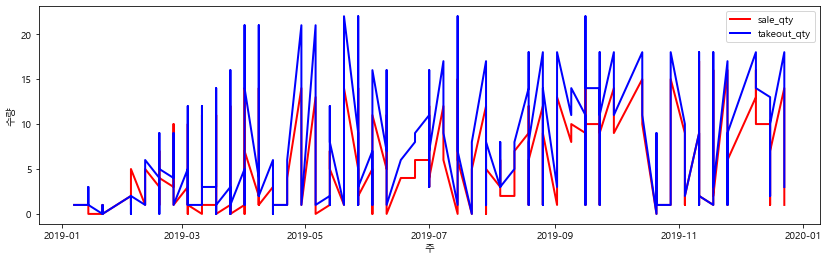

모다대전(대-위) 2019-04-15
84


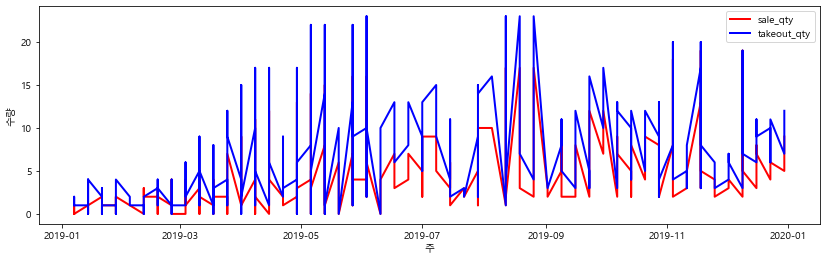

춘천(대-위) 2019-04-01
78


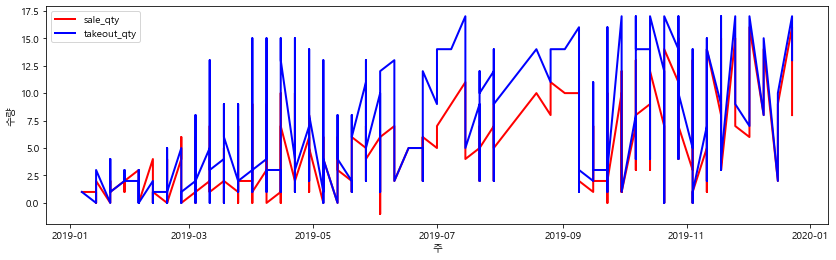

신세계대구 2019-04-15
163


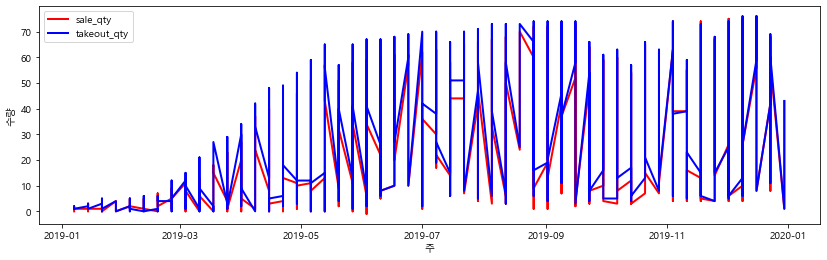

원주중앙(대-위) 2019-04-22
88


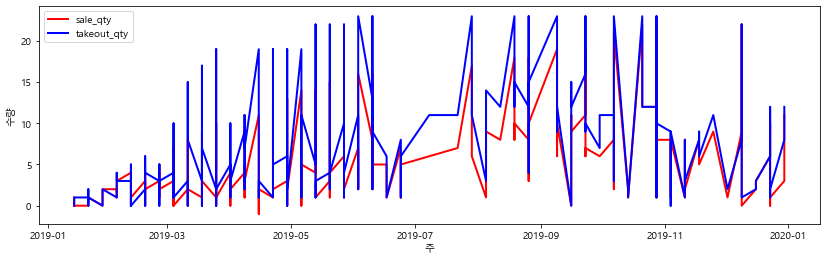

AK원주 2019-08-12
95


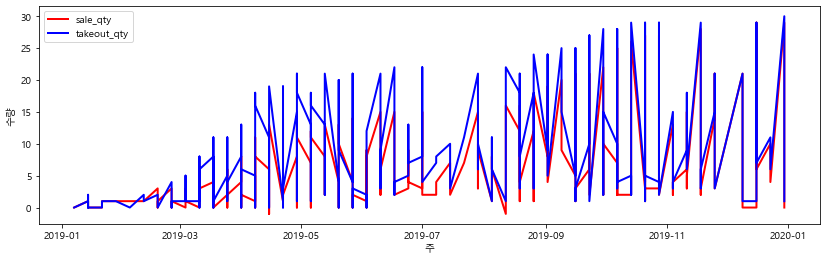

대구성서(대-위) 2019-04-08
92


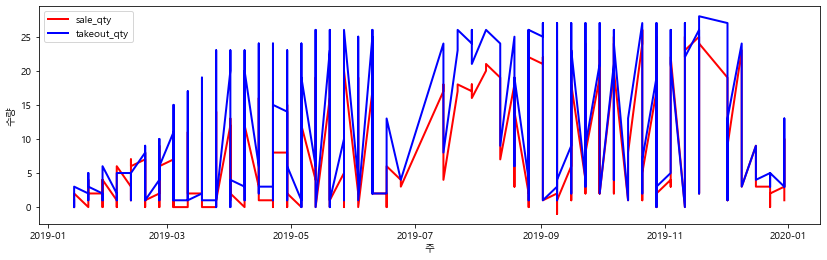

강릉(대-위) 2019-04-29
95


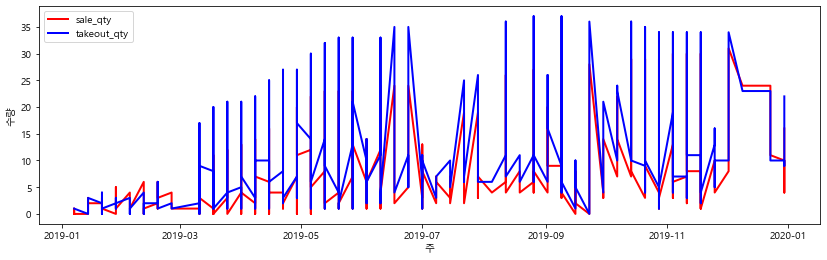

세이대전 2019-07-29
86


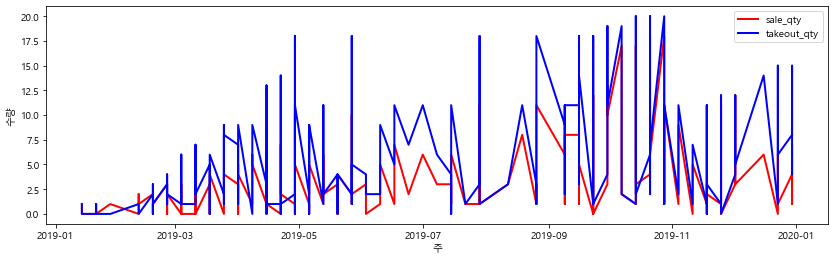

패션아일랜드(대-위) 2019-07-29
57


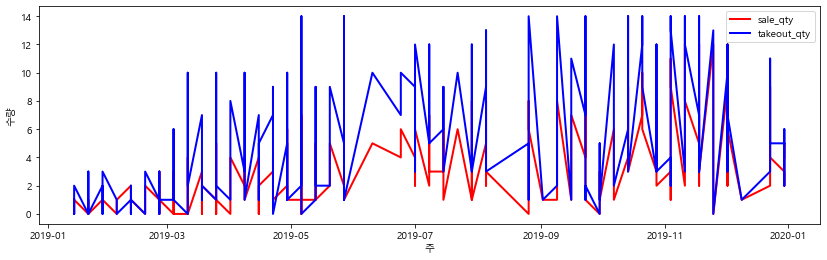

현대충청 2019-03-25
101


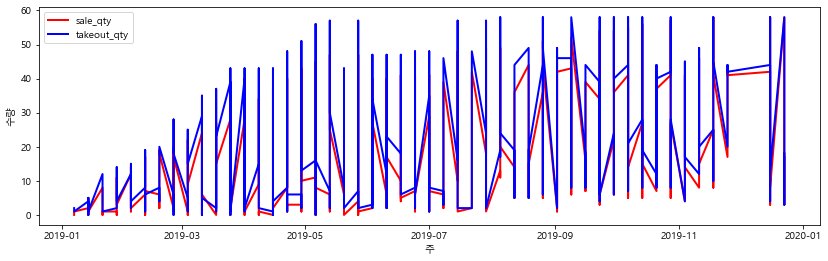

제천(대-위) 2019-04-29
96


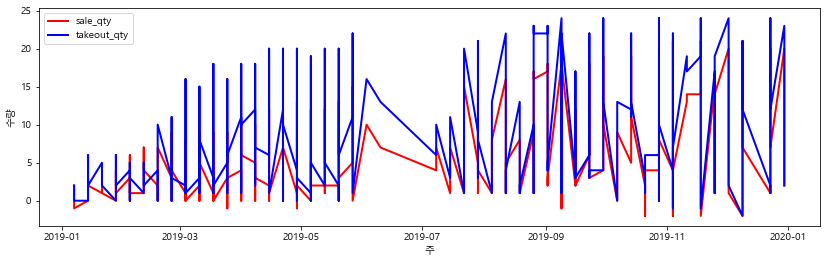

에버세이브청주(대-위) 2019-05-13
55


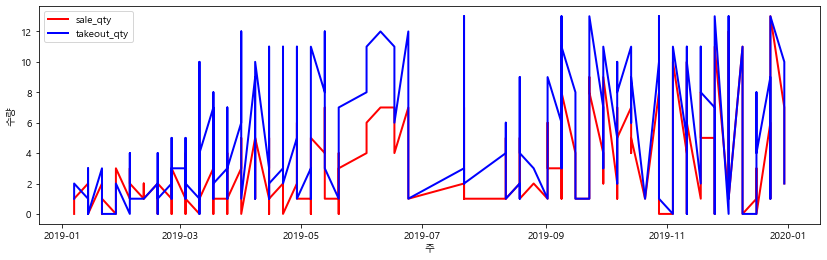

롯데대구 2019-05-13
121


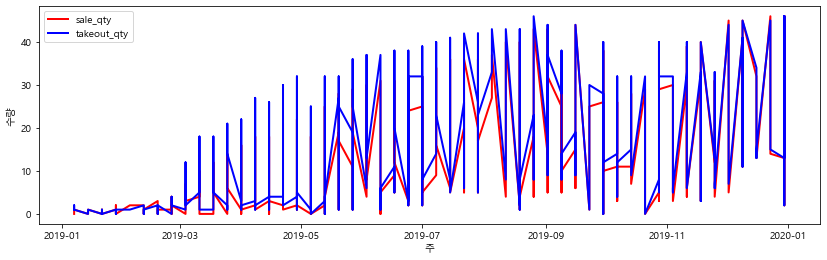

롯데대전 2019-04-15
120


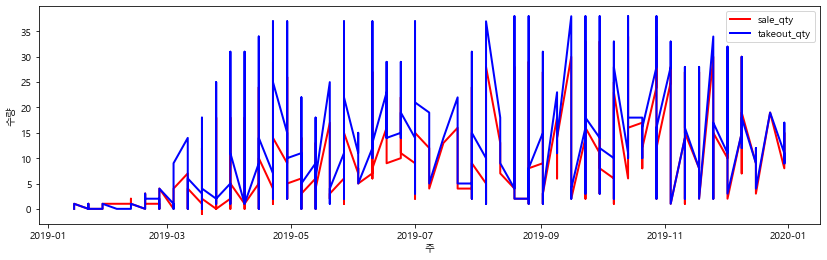

제주(대-위) 2019-05-20
72


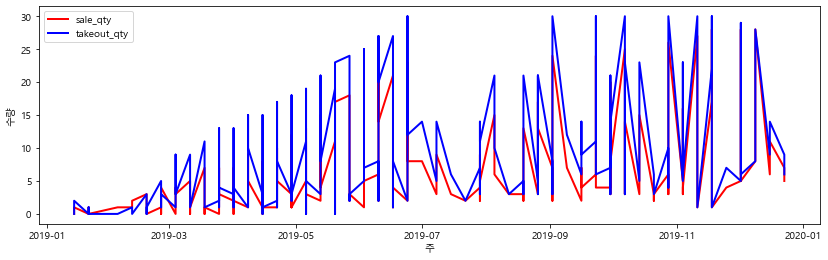

서귀포(대-위) 2019-09-30
69


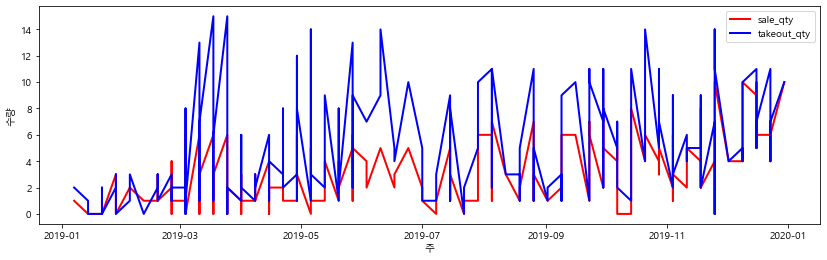

대전은행(대-위) 2019-03-18
143


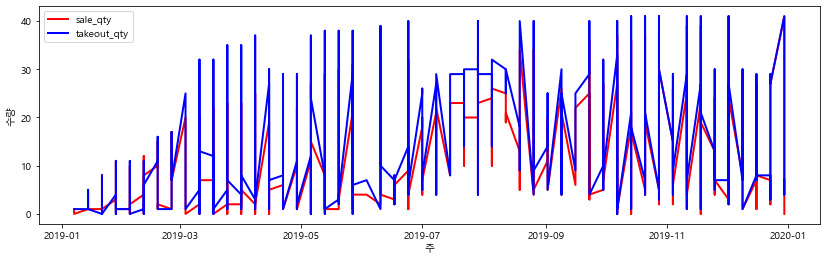

갤러리아대전 2019-04-08
174


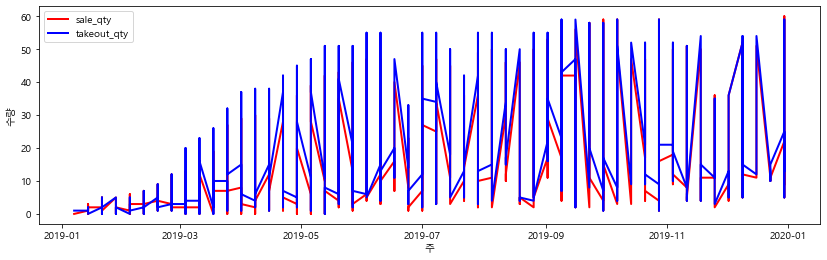

청주성안(대-위) 2019-03-11
170


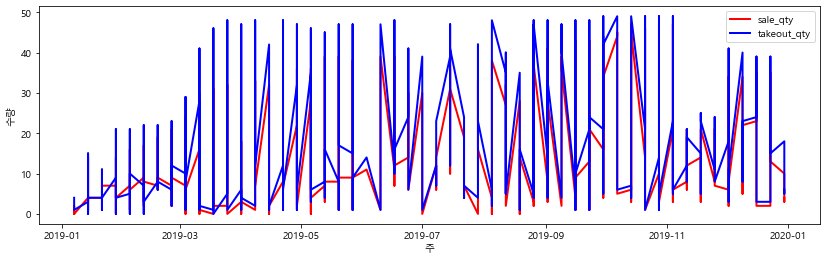

신세계스타일마켓 2019-04-08
129


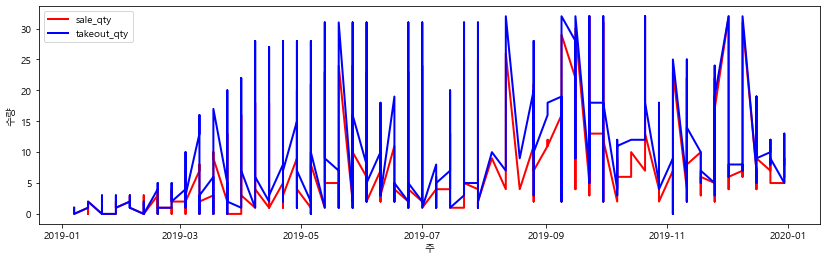

현대대구 2019-04-01
173


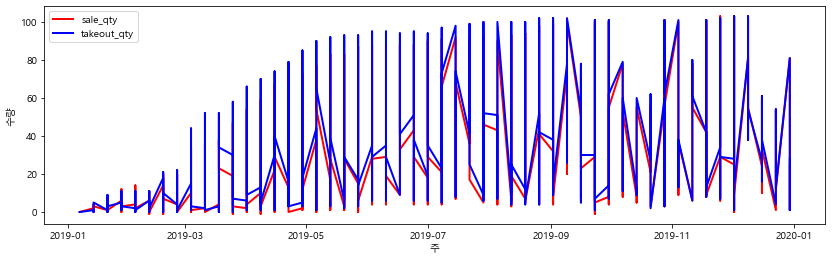

신제주(대-위) 2019-04-29
81


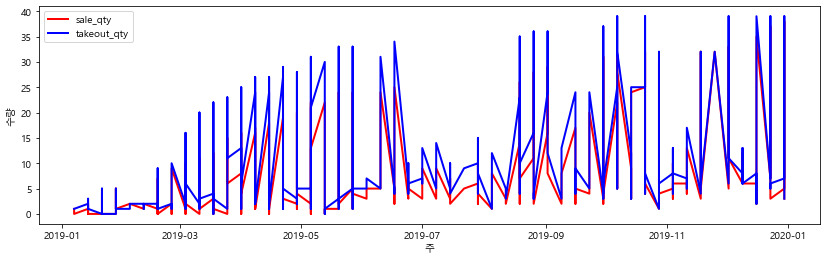

롯데상인 2019-05-06
90


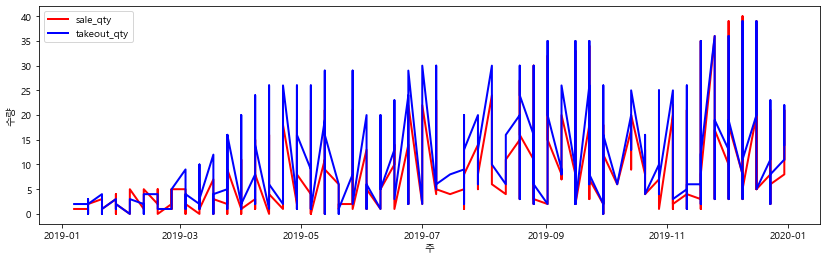

In [59]:
for i in df_shop[df_shop['region_nm'].str.contains("강원|대구|대전|충북|제주")]['shopkey']:
    
    shop_week= shop_stock_2019[(shop_stock_2019['shopkey']==i) & (shop_stock_2019['partkey']=='X19SDXSH09911') ].sort_values('weekkey')[['weekkey','week_takeout_qty','week_sale_qty','sale_qty','stock_qty','takeout_qty']].sort_values('weekkey')
    plt.plot(shop_week['weekkey'], shop_week['sale_qty'],'r')
    plt.plot(shop_week['weekkey'], shop_week['takeout_qty'],'b')
    shop_week[shop_week['sale_qty']> shop_week['takeout_qty'].max() / 2].iloc[0]['weekkey']
    print( df_shop[df_shop['shopkey']==i]['shop_nm'].iloc[0], shop_week[shop_week['sale_qty']> shop_week['takeout_qty'].max() / 2].iloc[0]['weekkey'])
    print(len(shop_week[(shop_week['sale_qty']>=shop_week['takeout_qty']) &  (shop_week['weekkey'] < datetime.date(2019,10,1)) ]))
    plt.legend(['sale_qty','takeout_qty'])
    plt.xlabel('주')
    plt.ylabel('수량')
    plt.show()

In [71]:
shop_stock_2019[(shop_stock_2019['shopkey']==i) & (shop_stock_2019['partkey']=='X19SDXSH09911') ].groupby(['weekkey','siz']).sum()

week_takeout_qty  takeout_qty  week_sale_qty  sale_qty  \
weekkey    siz                                                           
2019-01-07 240                 1            2              1         1   
2019-01-14 230                -1            0              0         0   
           235                -1            0              0         0   
           240                 2            6              1         2   
           250                -2            0              0         0   
           260                 1            2              1         1   
           265                 1            1              0         0   
           270                 1            2              2         2   
2019-01-21 230                 1            1              1         1   
           235                 0            1              1         1   
           240                -2            4              0         2   
           265                -1            0              0         0   
           270                 1            4              1         3   
           290                 1            1              1         1   
2019-01-28 230                 3            4              3         4   
           240                 0            4              0         2   
           250                 1            1              2         2   
           260                -1            1              0         1   
           265                 3            3              3         3   
           270                -1            3              1         4   
           280                 1            1              0         0   
           290                 2            3              1         2   
2019-02-04 230                 0            0              1         1   
           250                 1            2              1         3   
           270                 0            3              1         5   
           280                -1            1              1         1   
2019-02-11 235                 0            1              2         3   
           240                -1            3              1         3   
           260                 0            1              1         1   
           270                 1            4              0         5   
           280                 1            2              0         1   
2019-02-18 230                 3            7              3         8   
           235                 5            5              1         2   
           240                 3            4              0         2   
           250                 1            1              0         0   
           260                 1            1              0         0   
           265                 1            4              0         3   
           280                 0            2              1         2   
           290                 1            1              0         0   
2019-02-25 230                 3            5              0         5   
           235                 0            5             -1         3   
           240                 0            3              1         3   
           250                 1            2              1         1   
           260                 1            2              0         1   
           265                 0            1              1         1   
           270                 1            5              0         5   
           280                -1            1              0         2   
2019-03-04 230                 5           13              0         7   
           235                 2            3              0         2   
           240                 2            7              1         5   
           245                 1            1              0         0   
           250                 2            4              0         3   
           260      

In [74]:
shop_stock_2019[(shop_stock_2019['partkey']=='X19SDXSH09911') ].groupby('siz').sum()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
siz,,,,,
225,2055,15255,1711,11039,4216
230,6618,99174,5761,75431,23743
235,7189,116001,6570,89375,26626
240,7962,143419,7918,115827,27592
245,4097,46125,3798,33829,12296
250,5736,79510,5143,60295,19215
255,1426,10376,1393,8395,1981
260,6030,80437,5212,58754,21683
265,6199,84657,5405,61587,23070


In [108]:
bucket_dwalker[bucket_dwalker['siz']=='240'].groupby('weekkey').sum()['week_takeout_qty'].sum()

7962

In [109]:
bucket_dwalker[bucket_dwalker['siz']=='240'].groupby('weekkey').sum()['week_sale_qty'].sum()

7918

In [111]:
bucket_dwalker

,shopkey,weekkey,partkey,scskey,brand,season,partcode,color,siz,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,week_sale_amt,stock_qty,sale_amt,gender
572,X10056,2019-02-11,X19SDXSH09911,X19SDXSH09911BE230,X,19S,DXSH09911,BE,230,1,1,0,1,0.00,0,119000.00,X
573,X10056,2019-03-04,X19SDXSH09911,X19SDXSH09911BE230,X,19S,DXSH09911,BE,230,1,6,0,4,0.00,2,496000.00,X
574,X10056,2019-04-15,X19SDXSH09911,X19SDXSH09911BE230,X,19S,DXSH09911,BE,230,-1,11,1,6,129000.00,5,754000.00,X
577,X10056,2019-02-11,X19SDXSH09911,X19SDXSH09911BE250,X,19S,DXSH09911,BE,250,1,3,2,3,248000.00,0,377000.00,X
578,X10056,2019-03-04,X19SDXSH09911,X19SDXSH09911BE250,X,19S,DXSH09911,BE,250,9,16,1,9,129000.00,7,1131000.00,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472596,X50002,2019-10-28,X19SDXSH09911,X19SDXSH09911GR275,X,19S,DXSH09911,GR,275,0,4,1,3,116000.00,1,340000.00,X
1472599,X50002,2019-03-25,X19SDXSH09911,X19SDXSH09911GR290,X,19S,DXSH09911,GR,290,2,3,0,1,0.00,2,119000.00,X
1472600,X50002,2019-05-20,X19SDXSH09911,X19SDXSH09911GR290,X,19S,DXSH09911,GR,290,2,5,1,2,121320.00,3,240320.00,X
1472601,X50002,2019-11-25,X19SDXSH09911,X19SDXSH09911GR290,X,19S,DXSH09911,GR,290,0,5,1,4,119000.00,1,478320.00,X


In [173]:
bucket_dwalker[(bucket_dwalker['scskey']=='X19SDXSH09911BE240') & (bucket_dwalker['shopkey']=='X10056' )].groupby('weekkey').sum()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
weekkey,,,,,
2018-12-31,1,1,0,0,1
2019-01-14,2,3,1,1,2
2019-01-21,0,3,1,2,1
2019-01-28,-1,2,0,2,0
2019-02-18,1,3,0,2,1
2019-02-25,0,3,1,3,0
2019-03-04,2,5,1,4,1
2019-03-11,6,11,1,5,6
2019-03-25,0,11,0,5,6


In [174]:
bucket_dwalker[(bucket_dwalker['scskey']=='X19SDXSH09911BE240')].groupby('weekkey').sum()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
weekkey,,,,,
2018-12-31,207,207,7,7,200
2019-01-07,0,36,17,21,15
2019-01-14,150,311,203,222,89
2019-01-21,81,433,162,388,45
2019-01-28,32,435,96,455,-20
2019-02-04,0,323,110,439,-116
2019-02-11,88,419,111,549,-130
2019-02-18,430,981,133,831,150
2019-02-25,122,1095,187,1013,82


In [175]:
bucket_dwalker[(bucket_dwalker['scskey']=='X19SDXSH09911BE240')].groupby('weekkey').sum()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
weekkey,,,,,
2018-12-31,207,207,7,7,200
2019-01-07,0,36,17,21,15
2019-01-14,150,311,203,222,89
2019-01-21,81,433,162,388,45
2019-01-28,32,435,96,455,-20
2019-02-04,0,323,110,439,-116
2019-02-11,88,419,111,549,-130
2019-02-18,430,981,133,831,150
2019-02-25,122,1095,187,1013,82


In [187]:
bucket_dwalker_shop_key = bucket_dwalker['shopkey'].unique()

In [124]:
total_takeout_qty = 0
for i in bucket_dwalker['shopkey'].unique():
    total_takeout_qty = total_takeout_qty +bucket_dwalker[(bucket_dwalker['scskey']=='X19SDXSH09911BE240') & (bucket_dwalker['shopkey']=='X10056' )].groupby('weekkey').sum()['takeout_qty'].max()
    
total_takeout_qty

2717

In [277]:
test

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
weekkey,,,,,
2018-12-31,207,207,7,7,200
2019-01-07,0,36,17,21,15
2019-01-14,150,311,203,222,89
2019-01-21,81,433,162,388,45
2019-01-28,32,435,96,455,-20
2019-02-04,0,323,110,439,-116
2019-02-11,88,419,111,549,-130
2019-02-18,430,981,133,831,150
2019-02-25,122,1095,187,1013,82


In [278]:
frame = bucket_dwalker[(bucket_dwalker['scskey']=='X19SDXSH09911BE240')].groupby('weekkey').sum()
for col in frame.columns:
    frame[col].values[:] = 0
frame = frame.reset_index()

In [280]:
test

,weekkey,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
0,2018-12-31,0,0,0,0,0
1,2019-01-07,0,0,0,0,0
2,2019-01-14,0,0,0,0,0
3,2019-01-21,0,0,0,0,0
4,2019-01-28,0,0,0,0,0
5,2019-02-04,0,0,0,0,0
6,2019-02-11,0,0,0,0,0
7,2019-02-18,0,0,0,0,0
8,2019-02-25,0,0,0,0,0
9,2019-03-04,0,0,0,0,0


In [281]:
test2 = bucket_dwalker[(bucket_dwalker['scskey']=='X19SDXSH09911BE240') & (bucket_dwalker['shopkey']=='X10056' )].groupby('weekkey').sum().reset_index()

In [282]:
test2

,weekkey,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
0,2018-12-31,1,1,0,0,1
1,2019-01-14,2,3,1,1,2
2,2019-01-21,0,3,1,2,1
3,2019-01-28,-1,2,0,2,0
4,2019-02-18,1,3,0,2,1
5,2019-02-25,0,3,1,3,0
6,2019-03-04,2,5,1,4,1
7,2019-03-11,6,11,1,5,6
8,2019-03-25,0,11,0,5,6
9,2019-04-01,0,11,0,5,6


In [283]:
test2.iloc[0]

weekkey             2018-12-31
week_takeout_qty             1
takeout_qty                  1
week_sale_qty                0
sale_qty                     0
stock_qty                    1
Name: 0, dtype: object

In [288]:
frame = bucket_dwalker[(bucket_dwalker['scskey']=='X19SDXSH09911BE240')].groupby('weekkey').sum()
for col in frame.columns:
    frame[col].values[:] = 0
frame = frame.reset_index()

test2 = bucket_dwalker[(bucket_dwalker['scskey']=='X19SDXSH09911BE240') & (bucket_dwalker['shopkey']=='X10056' )].groupby('weekkey').sum().reset_index()

for i in range(0,len(test2)):
    for j in range(0,len(test)):
            if test2.iloc[i].weekkey == frame.iloc[j].weekkey:
                frame.iloc[j] = test2.iloc[i]
                break
for i in range(1,len(test)):
    if frame.iloc[i].takeout_qty ==0 and frame.iloc[i].sale_qty==0:
        frame.iloc[i] = [ frame.iloc[i]['weekkey'] ,0,frame.iloc[i-1]['takeout_qty'],0,frame.iloc[i-1]['sale_qty'],frame.iloc[i-1]['stock_qty']]

In [289]:
frame

,weekkey,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
0,2018-12-31,1,1,0,0,1
1,2019-01-07,0,1,0,0,1
2,2019-01-14,2,3,1,1,2
3,2019-01-21,0,3,1,2,1
4,2019-01-28,-1,2,0,2,0
5,2019-02-04,0,2,0,2,0
6,2019-02-11,0,2,0,2,0
7,2019-02-18,1,3,0,2,1
8,2019-02-25,0,3,1,3,0
9,2019-03-04,2,5,1,4,1


In [286]:
for i in range(1,len(test)):
    if test.iloc[i].takeout_qty ==0 and test.iloc[i].sale_qty==0:
        test.iloc[i] = [ test.iloc[i]['weekkey'] ,0,test.iloc[i-1]['takeout_qty'],0,test.iloc[i-1]['sale_qty'],test.iloc[i-1]['stock_qty']]

In [287]:
test

,weekkey,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
0,2018-12-31,1,1,0,0,1
1,2019-01-07,0,1,0,0,1
2,2019-01-14,2,3,1,1,2
3,2019-01-21,0,3,1,2,1
4,2019-01-28,-1,2,0,2,0
5,2019-02-04,0,2,0,2,0
6,2019-02-11,0,2,0,2,0
7,2019-02-18,1,3,0,2,1
8,2019-02-25,0,3,1,3,0
9,2019-03-04,2,5,1,4,1


In [153]:
for i in range(0,len(test)):
    print(i)


weekkey
week_takeout_qty
takeout_qty
week_sale_qty
sale_qty
stock_qty


In [186]:
bucket_dwalker[(bucket_dwalker['scskey']=='X19SDXSH09911BE240') & (bucket_dwalker['shopkey']=='X10056' )].groupby('weekkey').sum()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
weekkey,,,,,
2018-12-31,1,1,0,0,1
2019-01-14,2,3,1,1,2
2019-01-21,0,3,1,2,1
2019-01-28,-1,2,0,2,0
2019-02-18,1,3,0,2,1
2019-02-25,0,3,1,3,0
2019-03-04,2,5,1,4,1
2019-03-11,6,11,1,5,6
2019-03-25,0,11,0,5,6


In [262]:
[0,test.iloc[i-1]['takeout_qty'],0,test.iloc[i-1]['sale_qty'],test.iloc[i-1]['stock_qty']]

<ipython-input-262-49cfc922be21>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.iloc[i-1]['week_takeout_qty'] = 0


In [263]:
test.iloc[i-1]['week_takeout_qty']

2

In [180]:
bucket_dwalker_v2[(bucket_dwalker_v2['scskey']=='X20SDXSHA5011OW260') & (bucket_dwalker_v2['shopkey']=='X10056' )].groupby('weekkey').sum()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
weekkey,,,,,
2019-11-18,1,1,0,0,1
2019-12-02,0,1,1,1,0
2019-12-09,2,3,0,1,2
2019-12-23,1,4,1,2,2
2019-12-30,0,4,0,2,2
2020-02-10,0,4,1,3,1
2020-02-17,6,10,2,5,5
2020-03-02,1,11,1,6,5
2020-03-09,1,12,1,7,5


In [179]:
bucket_dwalker_v2[(bucket_dwalker_v2['partkey']=='X20SDXSHA5011')]

,shopkey,weekkey,partkey,scskey,brand,season,partcode,color,siz,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,week_sale_amt,stock_qty,sale_amt,gender
2603,X10056,2020-02-10,X20SDXSHA5011,X20SDXSHA5011OW230,X,20S,DXSHA5011,OW,230,0,6,1,3,139000.00,3,407000.00,X
2604,X10056,2020-06-15,X20SDXSHA5011,X20SDXSHA5011OW230,X,20S,DXSHA5011,OW,230,1,9,0,6,0.00,3,814000.00,X
2605,X10056,2020-12-07,X20SDXSHA5011,X20SDXSHA5011OW230,X,20S,DXSHA5011,OW,230,0,10,1,8,139000.00,2,1092000.00,X
2606,X10056,2020-02-10,X20SDXSHA5011,X20SDXSHA5011OW260,X,20S,DXSHA5011,OW,260,0,4,1,3,139000.00,1,407000.00,X
2607,X10056,2020-04-27,X20SDXSHA5011,X20SDXSHA5011OW260,X,20S,DXSHA5011,OW,260,0,12,1,9,139000.00,3,1241000.00,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1655155,X50002,2020-02-17,X20SDXSHA5011,X20SDXSHA5011OW270,X,20S,DXSHA5011,OW,270,0,9,1,7,132050.00,2,916050.00,X
1655156,X50002,2020-04-06,X20SDXSHA5011,X20SDXSHA5011OW270,X,20S,DXSHA5011,OW,270,2,16,2,13,242000.00,3,1670558.00,X
1655157,X50002,2020-05-25,X20SDXSHA5011,X20SDXSHA5011OW270,X,20S,DXSHA5011,OW,270,4,25,0,20,0.00,5,2574658.00,X
1655158,X50002,2020-06-08,X20SDXSHA5011,X20SDXSHA5011OW270,X,20S,DXSHA5011,OW,270,0,25,1,21,129000.00,4,2703658.00,X


In [201]:
bucket_dwalker[(bucket_dwalker['scskey']=='X19SDXSH09911BE240') & (bucket_dwalker['shopkey']=='X10056' )].groupby('weekkey').sum()['week_takeout_qty'].sum()

19

In [200]:
bucket_dwalker[(bucket_dwalker['scskey']=='X19SDXSH09911BE240') & (bucket_dwalker['shopkey']=='X10056' )].groupby('weekkey').sum()['week_takeout_qty']

weekkey
2018-12-31    1
2019-01-14    2
2019-01-21    0
2019-01-28   -1
2019-02-18    1
2019-02-25    0
2019-03-04    2
2019-03-11    6
2019-03-25    0
2019-04-01    0
2019-04-08    0
2019-04-22    3
2019-04-29    2
2019-05-06    0
2019-05-13    2
2019-05-20    1
2019-05-27   -1
2019-07-29    1
2019-09-09    0
2019-09-16    0
2019-09-30    0
2019-11-18    0
2019-11-25   -2
2019-12-02    2
Name: week_takeout_qty, dtype: int64

In [208]:
bucket_dwalker_shop_key = bucket_dwalker['shopkey'].unique()
bk_takeout_qty_sum=0
bk_sale_qty_sum=0
for shop in bucket_dwalker_shop_key:
    bk_takeout_qty_sum = bk_takeout_qty_sum +bucket_dwalker[(bucket_dwalker['scskey']=='X19SDXSH09911BE240') & (bucket_dwalker['shopkey']==shop )].groupby('weekkey').sum()['week_takeout_qty'].sum()
    bk_sale_qty_sum = bk_sale_qty_sum+bucket_dwalker[(bucket_dwalker['scskey']=='X19SDXSH09911BE240') & (bucket_dwalker['shopkey']==shop )].groupby('weekkey').sum()['week_sale_qty'].sum()

In [209]:
bk_takeout_qty_sum

4732

In [210]:
bk_sale_qty_sum

4731

In [197]:
takeout_qty_sum

4973

In [198]:
sale_qty_sum

4757

In [ ]:
bucket_dwalker_shop_key = bucket_dwalker['shopkey'].unique()
takeout_qty_sum=0
sale_qty_sum=0
for shop in bucket_dwalker_v2:
    takeout_qty_sum = takeout_qty_sum +bucket_dwalker_v2[(bucket_dwalker_v2['scskey']=='X19SDXSH09911BE240') & (bucket_dwalker_v2['shopkey']==shop )].groupby('weekkey').sum()['week_takeout_qty'].sum()
    sale_qty_sum = sale_qty_sum+bucket_dwalker[(bucket_dwalker_v2['scskey']=='X19SDXSH09911BE240') & (bucket_dwalker['shopkey']==shop )].groupby('weekkey').sum()['week_sale_qty'].sum()

# 로직이다아아아

In [452]:
# 로직

def zero_fill(shopkey, base):
    total=[]
    for col in base.columns:
        base[col].values[:] = 0
    for shop in shopkey:
        frame = base.reset_index()
        
        test2 = bucket_dwalker[(bucket_dwalker['scskey']=='X19SDXSH09911BE240') & (bucket_dwalker['shopkey']==shop )].groupby('weekkey').sum().reset_index()

        for i in range(0,len(test2)):
            for j in range(0,len(test)):
                    if test2.iloc[i].weekkey == frame.iloc[j].weekkey:
                        frame.iloc[j] = test2.iloc[i]
                        break
        for i in range(1,len(test)):
            if frame.iloc[i].takeout_qty ==0 and frame.iloc[i].sale_qty==0:
                frame.iloc[i] = [ frame.iloc[i]['weekkey'], 0, frame.iloc[i-1]['takeout_qty'], 0, frame.iloc[i-1]['sale_qty'], frame.iloc[i-1]['stock_qty']]
        frame['shopkey'] =shop
        frame['ratio'] = 0
        for i in range(0,len(frame)):
            total_sale_qty= frame['week_sale_qty'].sum()
            a = frame.iloc[i]
            if a['sale_qty']==0 :
                frame.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , 0]
            else:
                if a['sale_qty'] / total_sale_qty > 1:
                    frame.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , 1]
                else:
                    frame.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , a['sale_qty'] / total_sale_qty]

        frame = pd.merge(frame, shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')
        total.append(frame)
    return total

In [454]:
frame = bucket_dwalker[(bucket_dwalker['scskey']=='X19SDXSH09911BE240')].groupby('weekkey').sum()
bucket_dwalker_shop_key = bucket_dwalker['shopkey'].unique()


shop_weeks = zero_fill(bucket_dwalker_shop_key, frame)

In [455]:
shop_weeks_df = pd.concat(shop_weeks)


In [456]:
shop_weeks_df.to_csv('shop_weeks_df.csv')

In [432]:
department_weeks_key = shop_weeks_df[shop_weeks_df['type_zone_nm']=='백화점']['shopkey'].unique()

In [433]:
agency_weeks_key = shop_weeks_df[shop_weeks_df['type_zone_nm']=='대리점']['shopkey'].unique()

In [435]:
agency_weeks_key

array(['X50088', 'X50121', 'X50077', 'X50006', 'X50128', 'X50090',
       'X50101', 'X50089', 'X50131', 'X50024', 'X50092', 'X50115',
       'X50125', 'X50098', 'X50064', 'X50019', 'X50103', 'X50042',
       'X50052', 'X50130', 'X50047', 'X50107', 'X50091', 'X50081',
       'X50117', 'X50023', 'X50129', 'X50074', 'X50113', 'X50099',
       'X50005', 'X50114', 'X50041', 'X50133', 'X50028', 'X50037',
       'X50123', 'X50055', 'X50094', 'X50053', 'X50063', 'X50069',
       'X50110', 'X50111', 'X50120', 'X50058', 'X50119', 'X50007',
       'X50116', 'X50062', 'X50073', 'X50015', 'X50078', 'X50096',
       'X50095', 'X50106', 'X50102', 'X50127', 'X50020', 'X50118',
       'X50059', 'X50001', 'X50122', 'X50104', 'X50057', 'X50045',
       'X50065', 'X50126', 'X50051', 'X50002'], dtype=object)

In [431]:
department_weeks

array(['X10056', 'X10046', 'X10027', 'X10070', 'X10061', 'X10081',
       'X10048', 'X10059', 'X10065', 'X10058', 'X10003', 'X10005',
       'X10029', 'X10068', 'X10051', 'X10028', 'X10052', 'X10008',
       'X10050', 'X10025', 'X10015', 'X10053', 'X10073', 'X10035',
       'X10080', 'X10060', 'X10076', 'X10067', 'X10022', 'X10016',
       'X10064', 'X10004', 'X10014', 'X10039', 'X10023', 'X10063',
       'X10011', 'X10036', 'X10078', 'X10077', 'X10079', 'X10006',
       'X10057', 'X10009', 'X10045', 'X10026', 'X10062', 'X10069',
       'X10032', 'X10043', 'X10020', 'X10082', 'X10085', 'X10018',
       'X10019', 'X10047', 'X10055', 'X10075', 'X10021', 'X10086',
       'X10034', 'X10033', 'X10044', 'X10007', 'X10041', 'X10030',
       'X10038'], dtype=object)

X10056


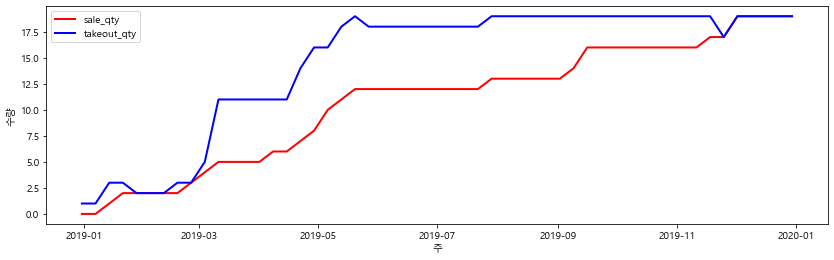

X10046


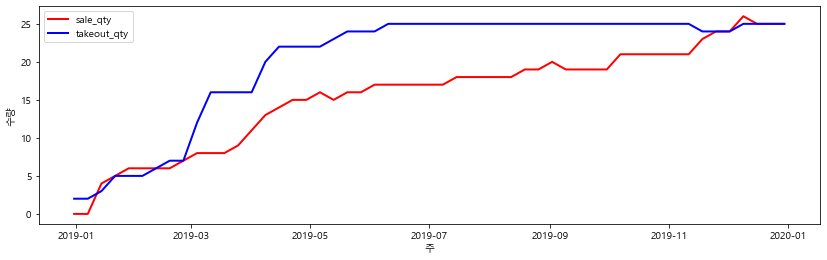

X10027


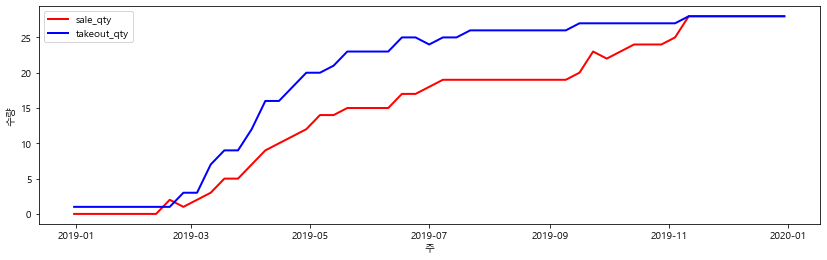

X10070


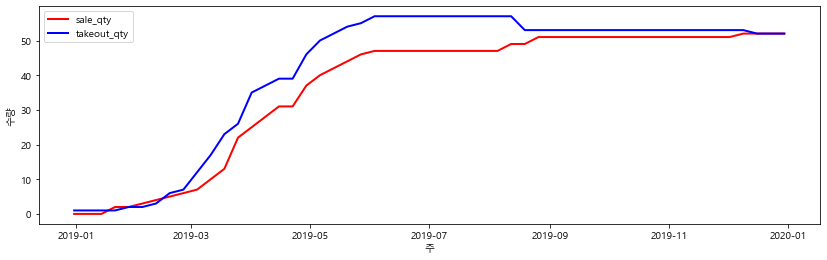

X10061


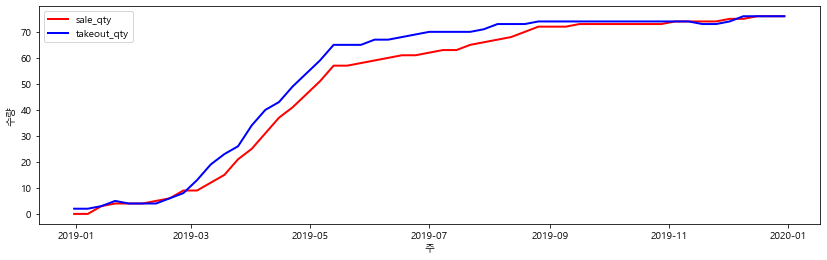

X10081


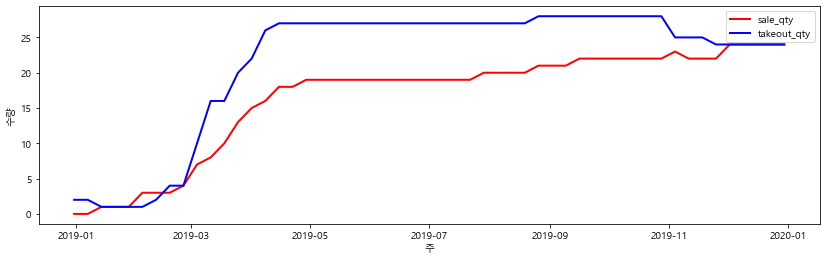

X10048


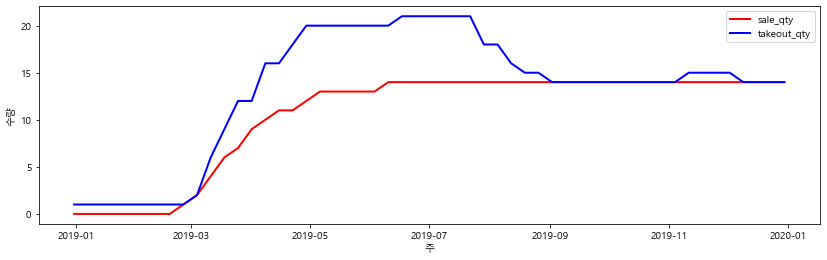

X10059


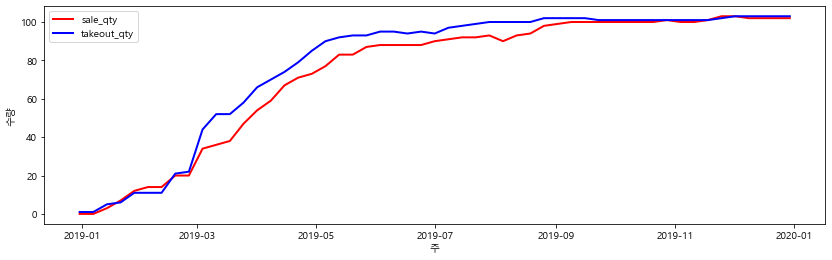

X10065


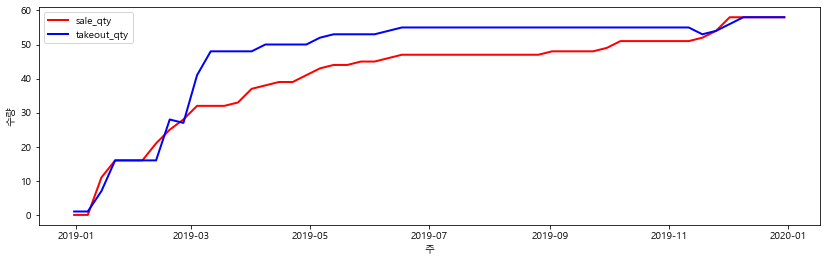

X10058


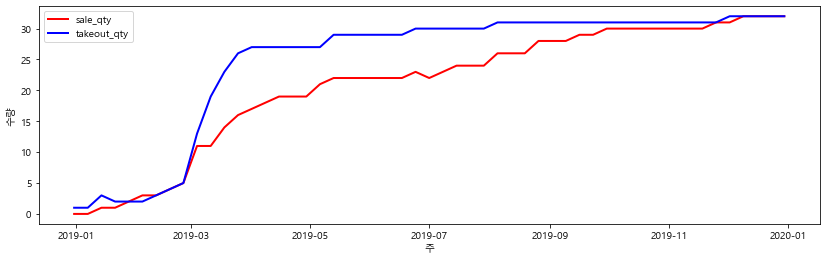

X10003


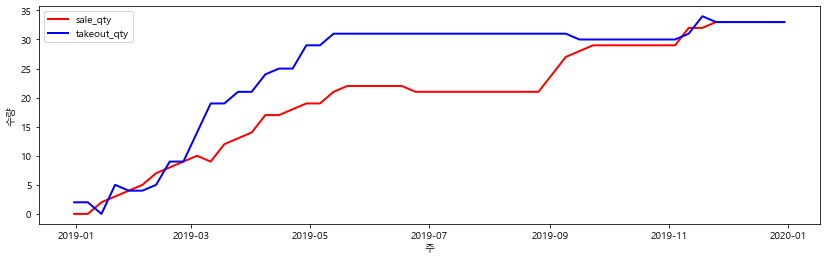

X10005


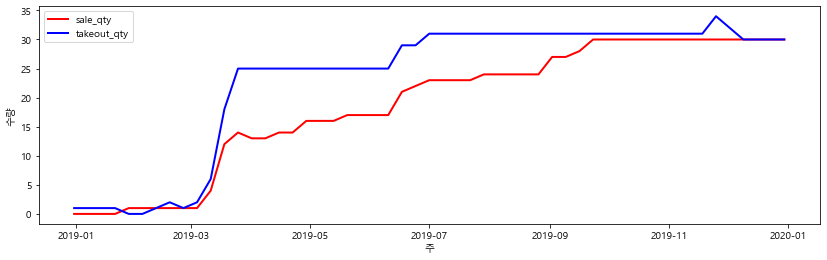

X10029


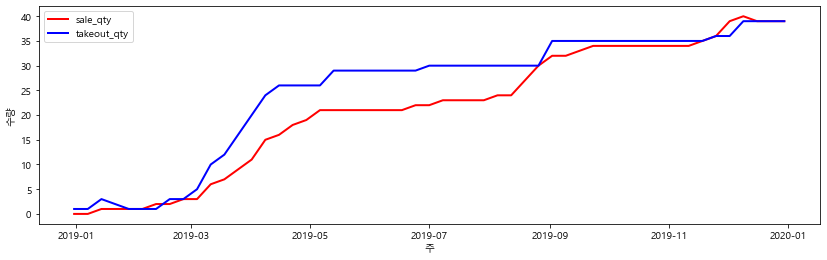

X10068


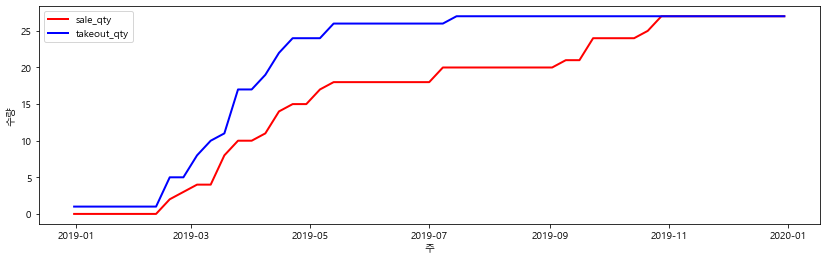

X10051


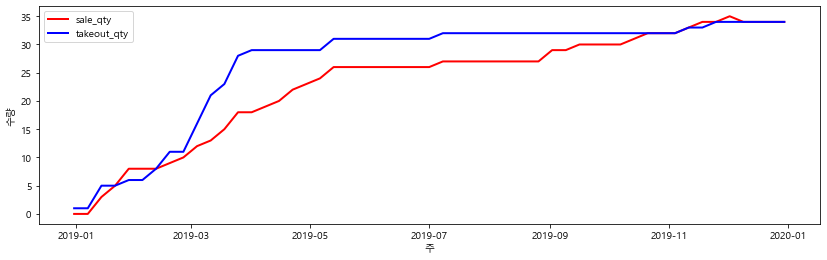

X10028


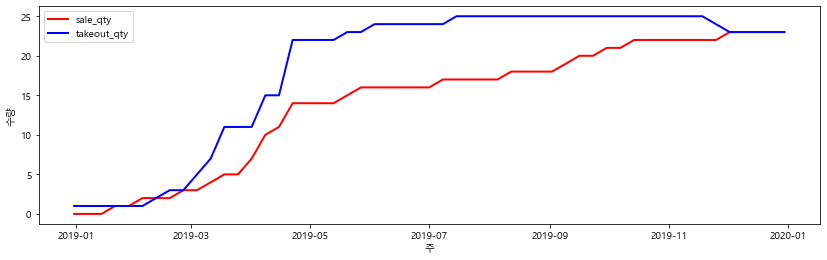

X10052


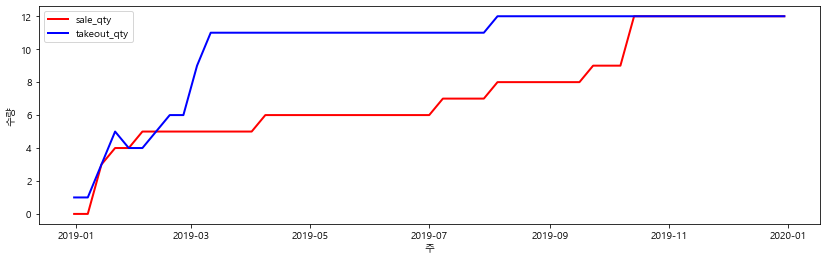

X10008


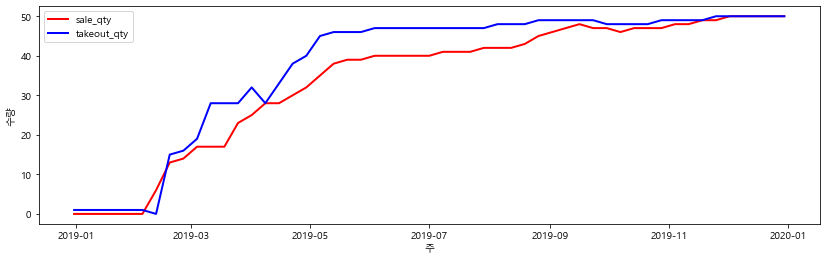

X10050


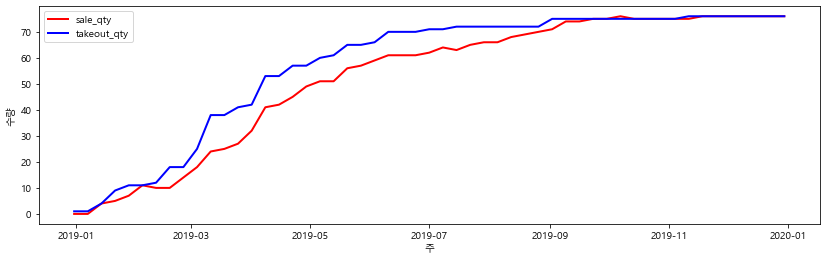

X10025


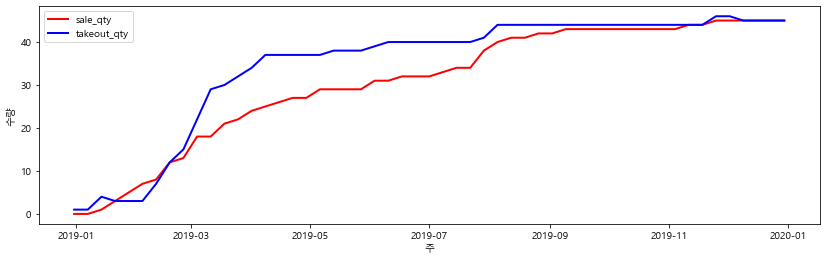

X10015


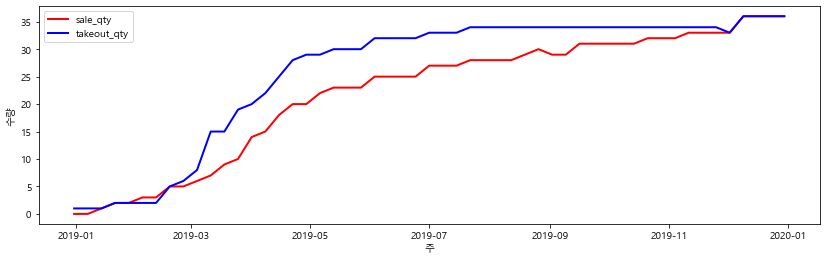

X10053


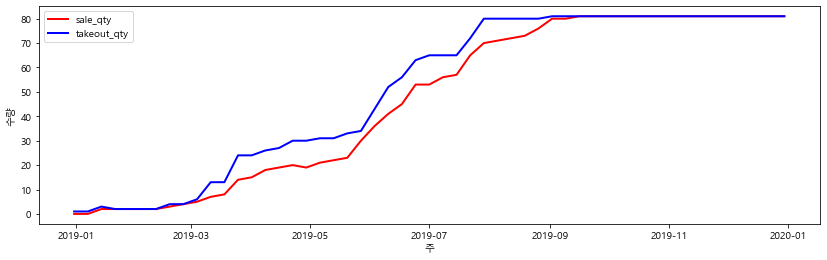

X10073


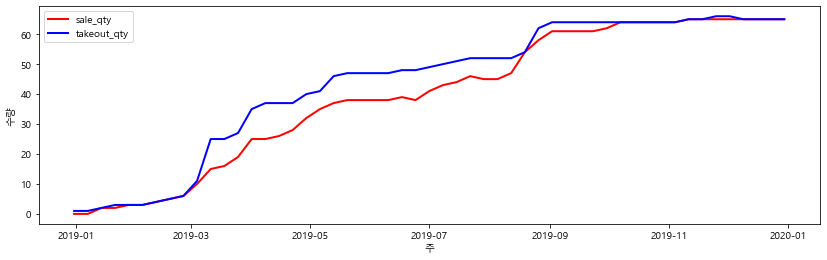

X10035


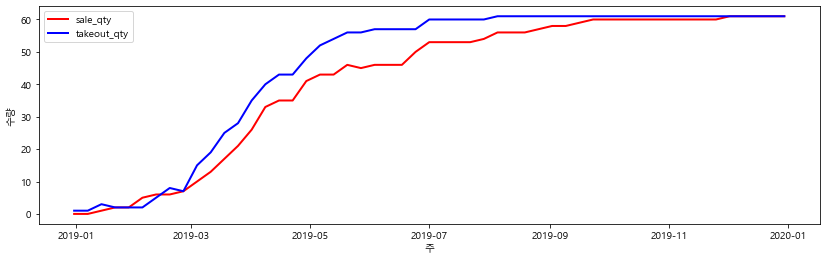

X10080


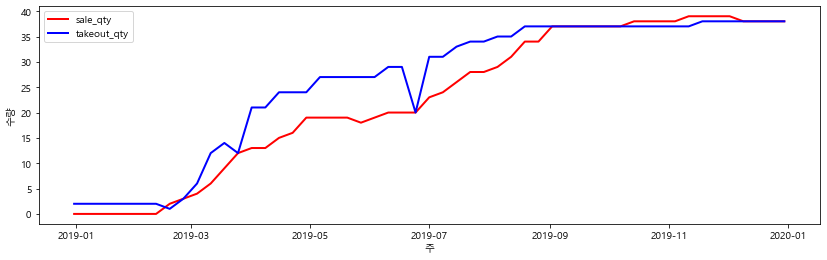

X10060


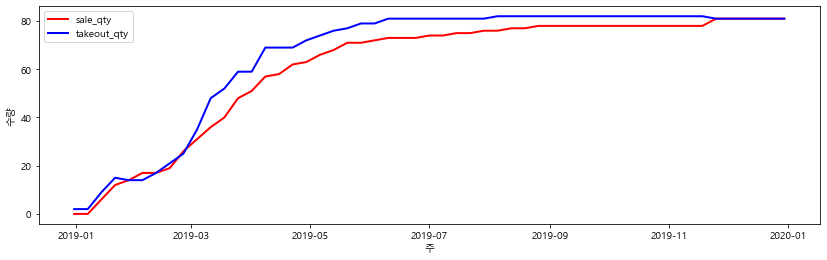

X10076


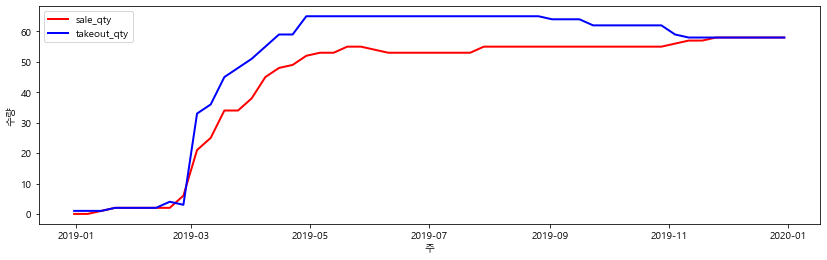

X10067


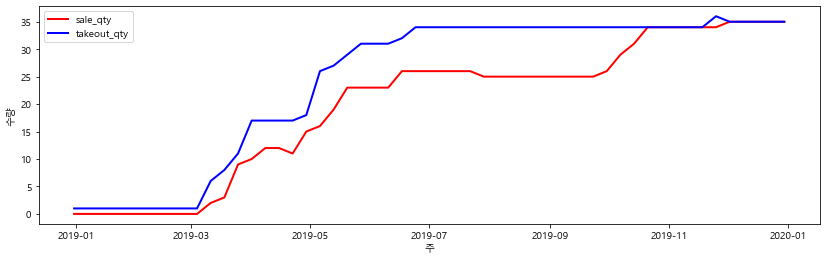

X10022


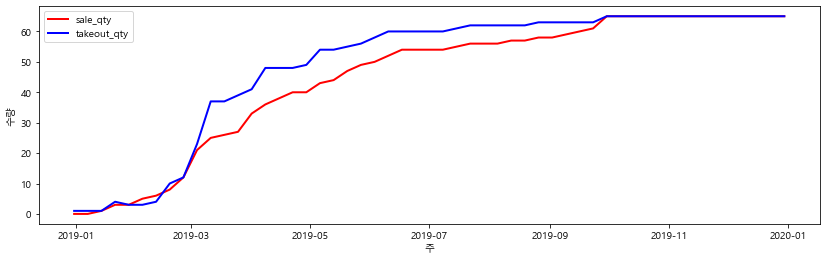

X10016


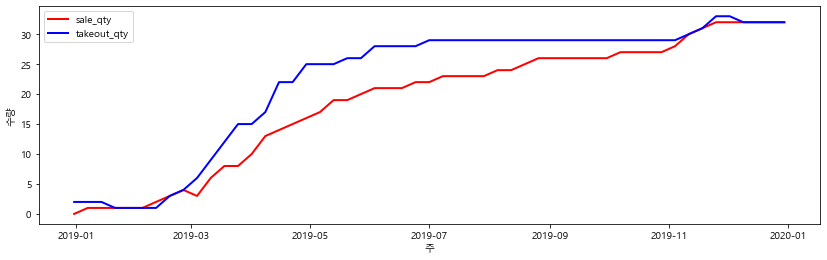

X10064


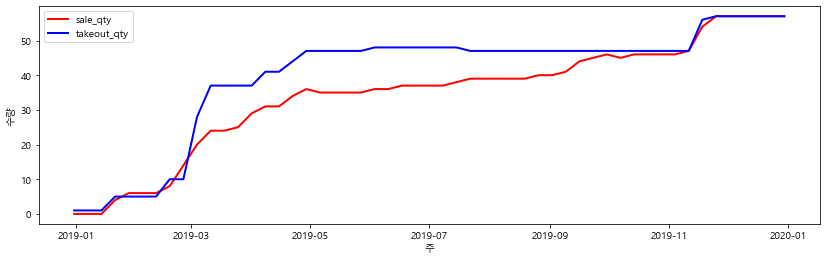

X10004


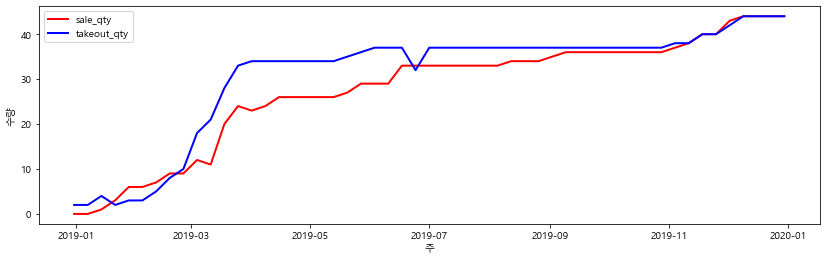

X10014


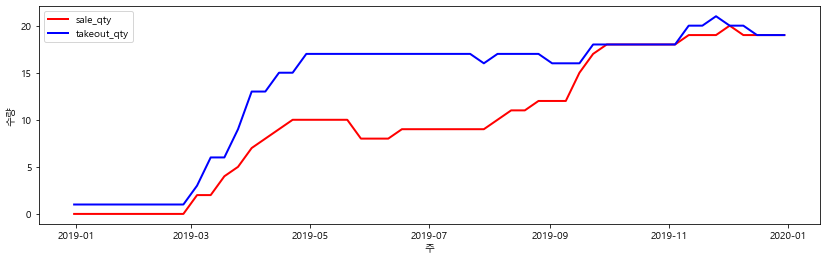

X10039


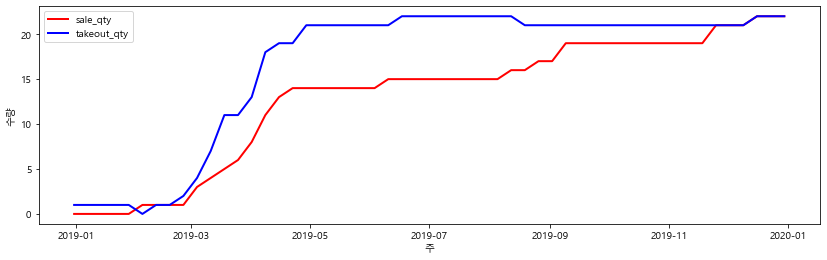

X10023


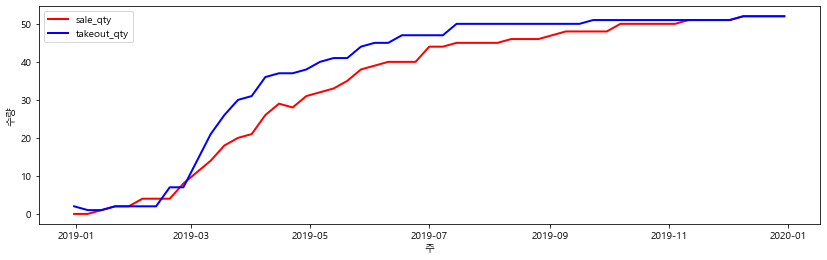

X10063


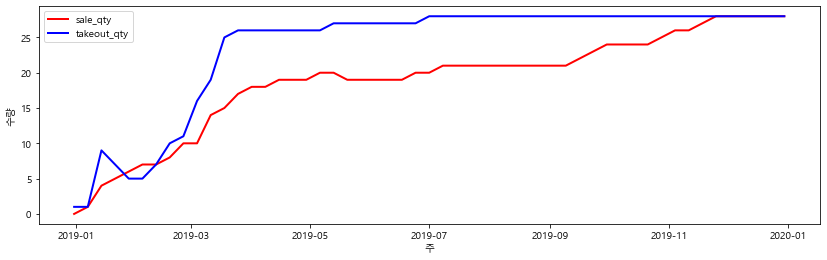

X10011


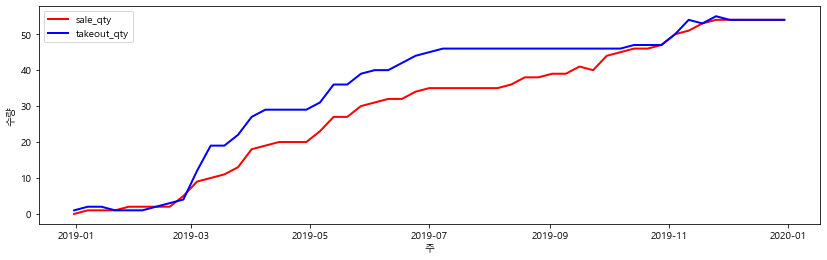

X10036


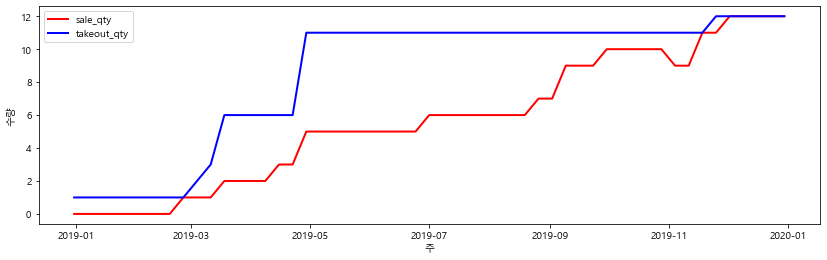

X10078


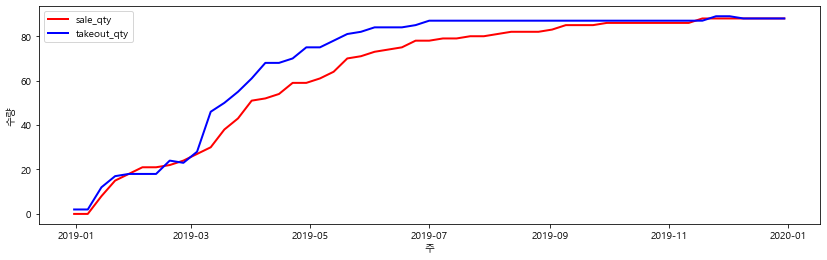

X10077


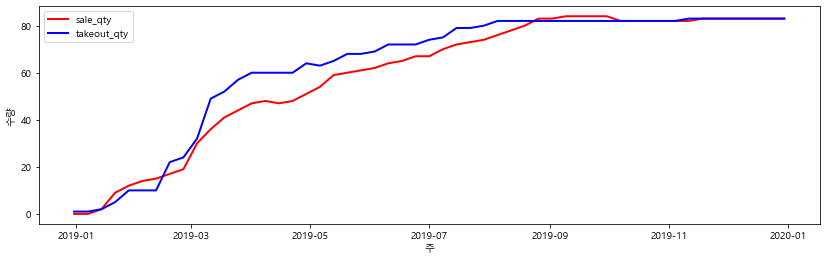

X10079


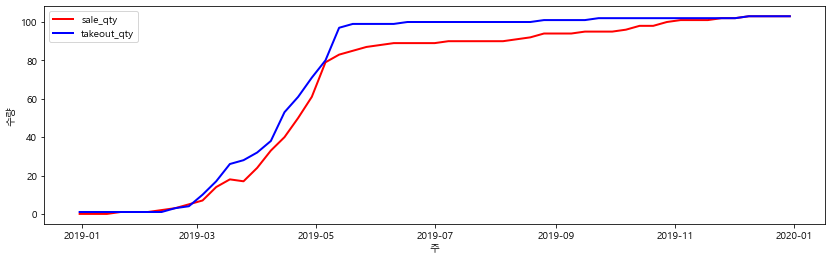

X10006


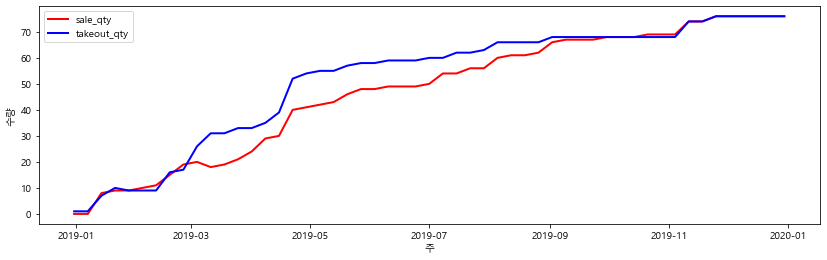

X10057


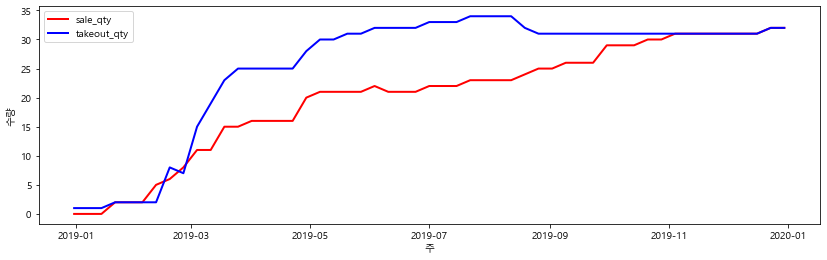

X10009


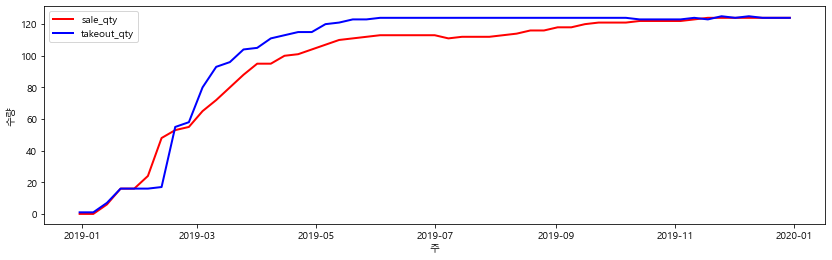

X10045


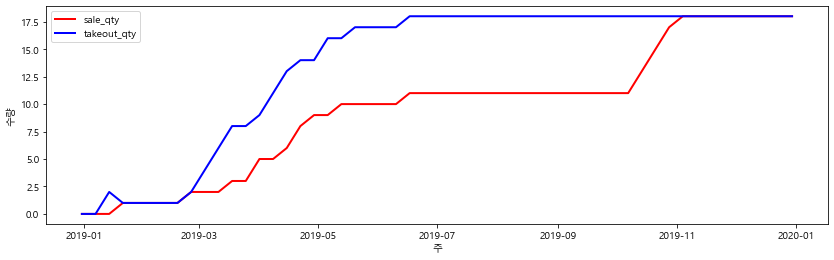

X10026


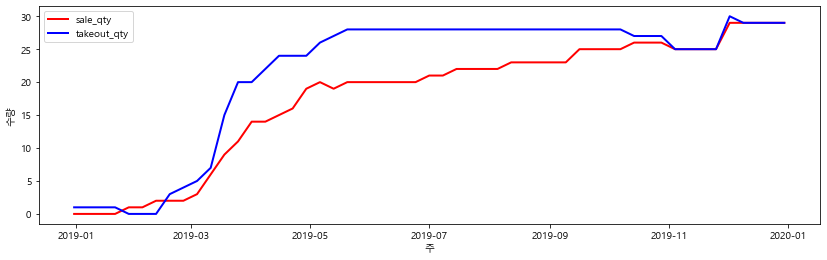

X10062


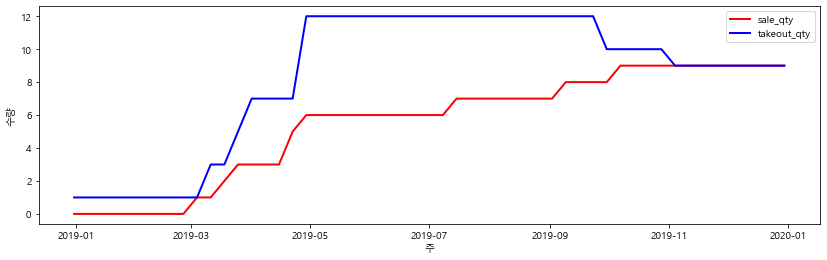

X10069


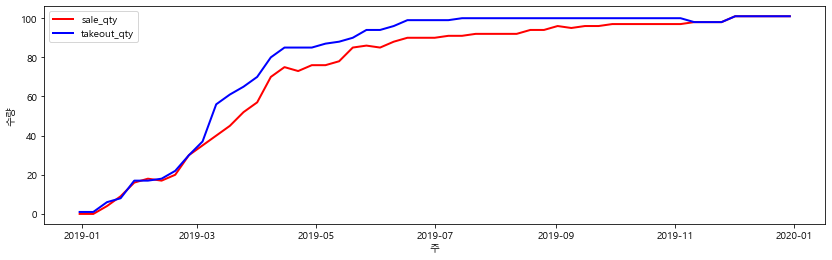

X10032


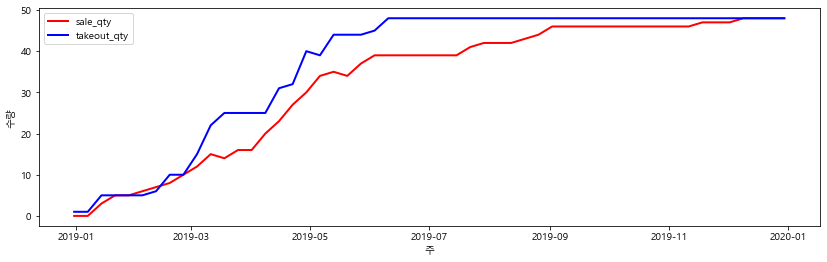

X10043


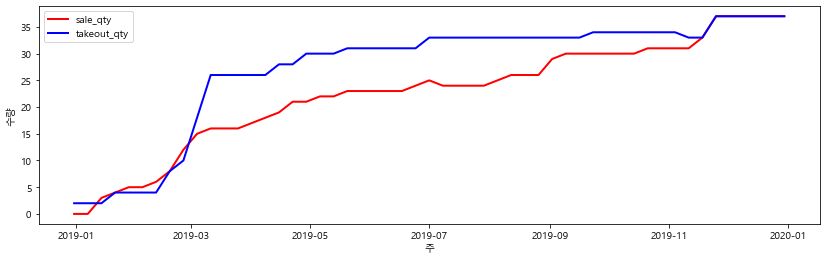

X10020


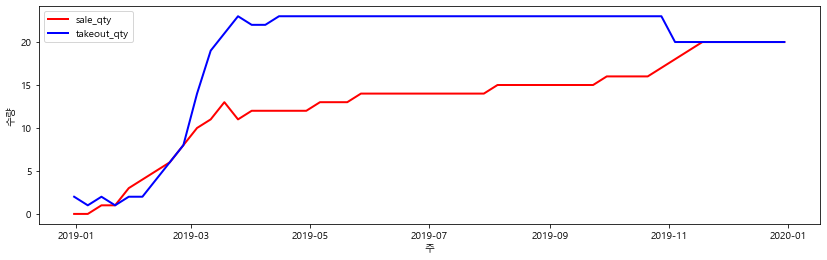

X10082


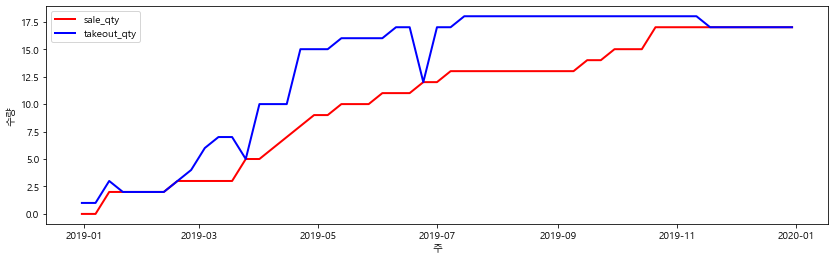

X10085


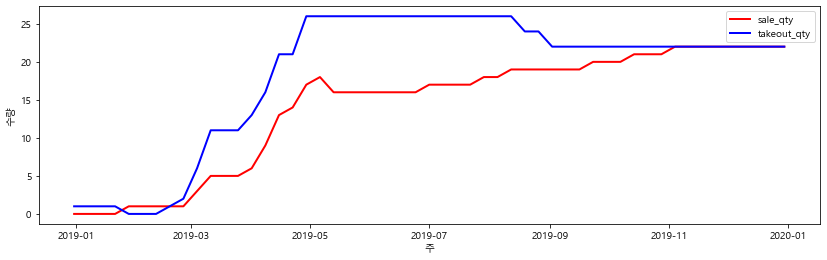

X10018


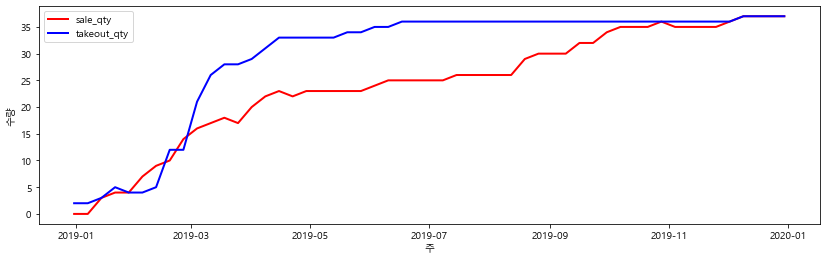

X10019


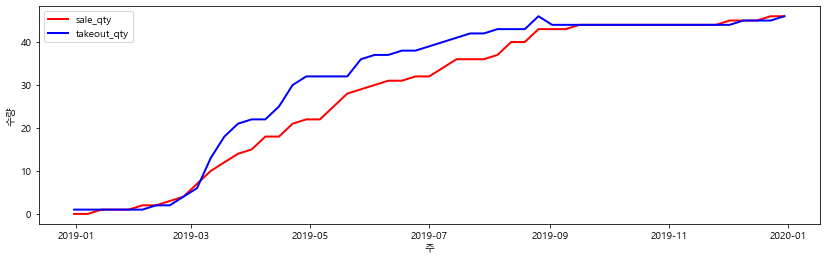

X10047


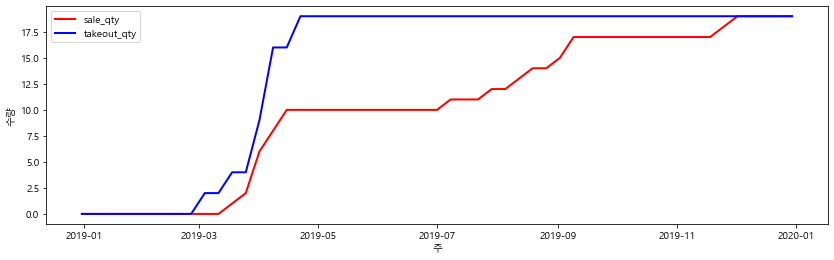

X10055


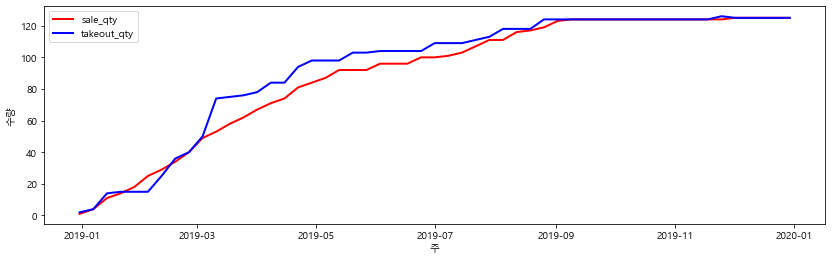

X10075


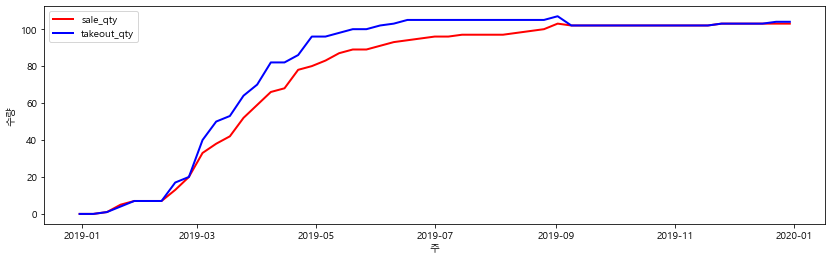

X10021


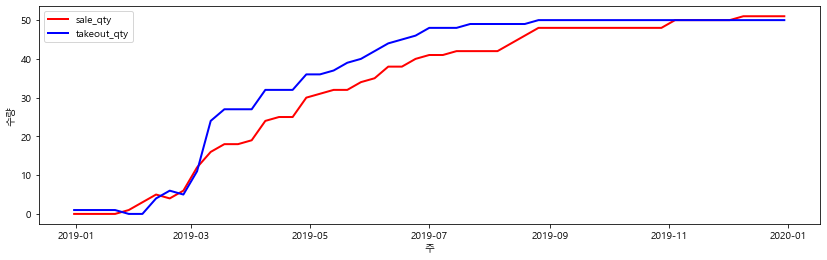

X10086


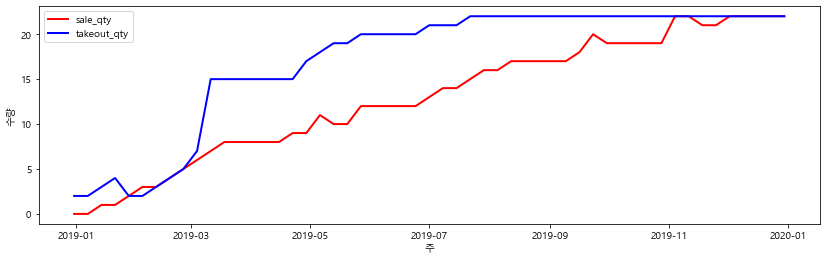

X10034


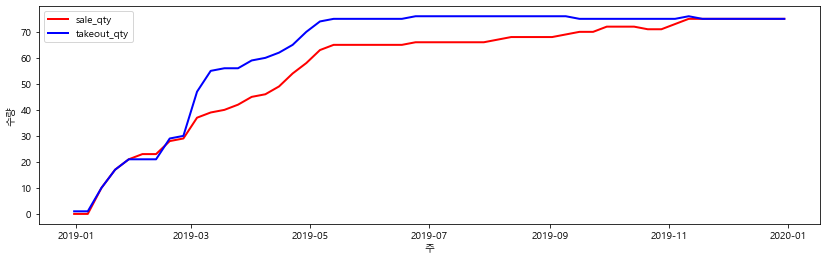

X10033


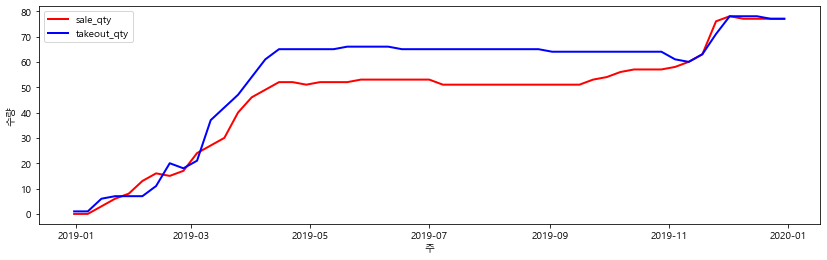

X10044


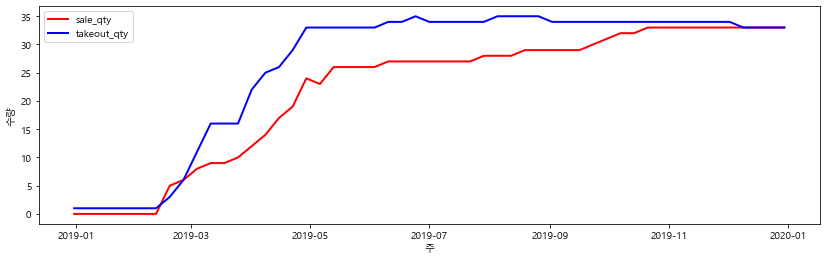

X10007


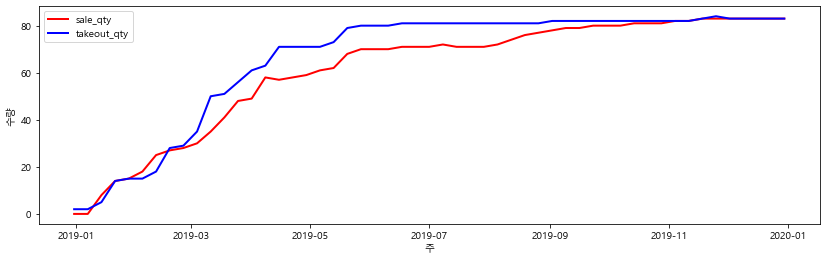

X10041


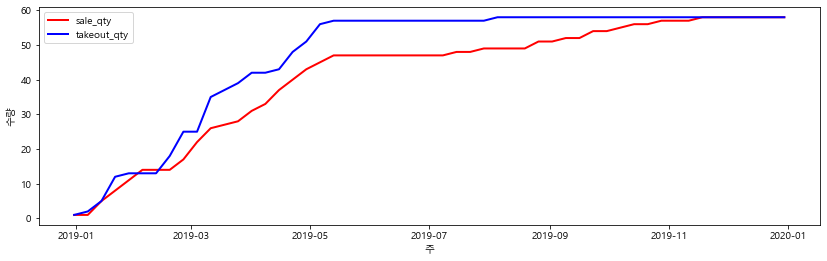

X10030


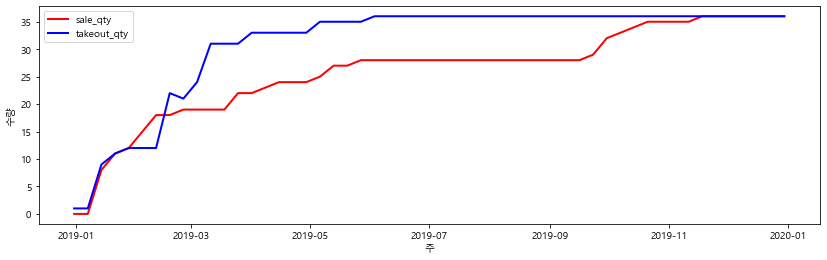

X10038


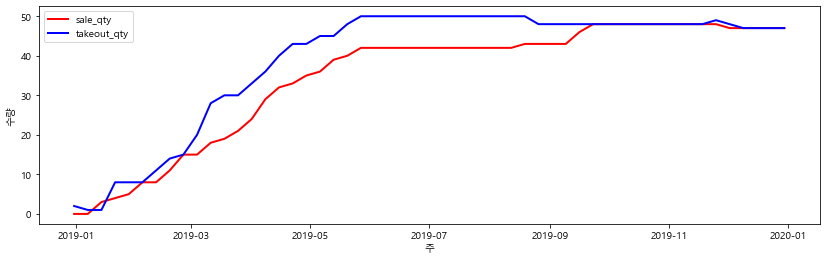

In [434]:
for shop_key in department_weeks_key:
    shop_week = shop_weeks_df[shop_weeks_df['shopkey']== shop_key]
    print(shop_week['shopkey'].iloc[0])
    plt.plot(shop_week['weekkey'], shop_week['sale_qty'],'r')
    plt.plot(shop_week['weekkey'], shop_week['takeout_qty'],'b')
    plt.legend(['sale_qty','takeout_qty'])
    plt.xlabel('주')
    plt.ylabel('수량')
    plt.show()

In [459]:
shop_weeks_df[shop_weeks_df['shopkey']=='X10056']

,weekkey,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty,shopkey,ratio,shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
0,2018-12-31,1,1,0,0,1,X10056,0.000000,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
1,2019-01-07,0,1,0,0,1,X10056,0.000000,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
2,2019-01-14,2,3,1,1,2,X10056,0.052632,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
3,2019-01-21,0,3,1,2,1,X10056,0.105263,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
4,2019-01-28,-1,2,0,2,0,X10056,0.105263,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
5,2019-02-04,0,2,0,2,0,X10056,0.105263,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
6,2019-02-11,0,2,0,2,0,X10056,0.105263,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
7,2019-02-18,1,3,0,2,1,X10056,0.105263,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
8,2019-02-25,0,3,1,3,0,X10056,0.157895,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
9,2019-03-04,2,5,1,4,1,X10056,0.210526,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남


In [469]:
department_weeks_mean = shop_weeks_df[shop_weeks_df['type_zone_nm']=='백화점'].groupby('weekkey').mean()
department_weeks_mean

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty,ratio
weekkey,,,,,,
2018-12-31,1.208955,1.208955,0.029851,0.029851,1.179104,0.000377
2019-01-07,0.014925,1.223881,0.089552,0.119403,1.104478,0.002011
2019-01-14,1.910448,3.119403,2.134328,2.253731,0.865672,0.044638
2019-01-21,1.417910,4.522388,1.626866,3.880597,0.641791,0.072018
2019-01-28,0.343284,4.805970,0.955224,4.835821,-0.029851,0.089816
2019-02-04,0.000000,4.791045,1.179104,6.014925,-1.223881,0.111736
2019-02-11,0.910448,5.686567,1.149254,7.134328,-1.447761,0.129803
2019-02-18,4.268657,9.880597,1.417910,8.552239,1.328358,0.156865
2019-02-25,1.014925,10.820896,1.865672,10.417910,0.402985,0.193613


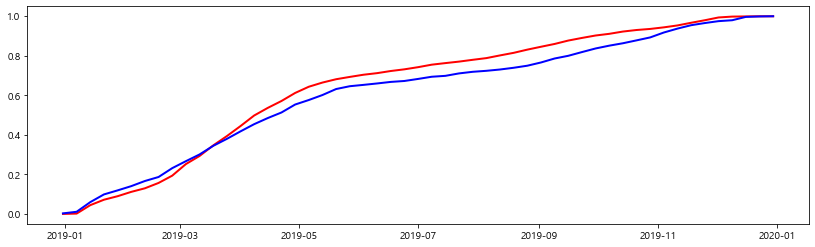

In [474]:
plt.plot(department_weeks_mean.index, department_weeks_mean['ratio'],'r')
plt.plot(agency_weeks_mean.index, agency_weeks_mean['ratio'],'b')
plt.show()

In [473]:
agency_weeks_mean = shop_weeks_df[shop_weeks_df['type_zone_nm']=='대리점'].groupby('weekkey').mean()
agency_weeks_mean

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty,ratio
weekkey,,,,,,
2018-12-31,1.642857,1.642857,0.057143,0.057143,1.585714,0.003110
2019-01-07,0.000000,1.642857,0.142857,0.200000,1.442857,0.011119
2019-01-14,0.414286,2.057143,0.814286,1.014286,1.042857,0.059889
2019-01-21,0.342857,2.400000,0.671429,1.685714,0.714286,0.098857
2019-01-28,0.085714,2.428571,0.428571,2.114286,0.314286,0.119241
2019-02-04,0.000000,2.385714,0.385714,2.500000,-0.114286,0.140713
2019-02-11,0.342857,2.700000,0.457143,2.957143,-0.257143,0.166623
2019-02-18,1.885714,4.571429,0.471429,3.414286,1.157143,0.186895
2019-02-25,0.700000,5.042857,0.828571,4.242857,0.800000,0.231576


In [475]:
agency_weeks_sum = shop_weeks_df[shop_weeks_df['type_zone_nm']=='대리점'].groupby('weekkey').sum()
agency_weeks_sum

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty,ratio
weekkey,,,,,,
2018-12-31,115,115,4,4,111,0.217700
2019-01-07,0,115,10,14,101,0.778316
2019-01-14,29,144,57,71,73,4.192205
2019-01-21,24,168,47,118,50,6.920011
2019-01-28,6,170,30,148,22,8.346842
2019-02-04,0,167,27,175,-8,9.849908
2019-02-11,24,189,32,207,-18,11.663575
2019-02-18,132,320,33,239,81,13.082678
2019-02-25,49,353,58,297,56,16.210351


In [472]:
department_weeks_sum = shop_weeks_df[shop_weeks_df['type_zone_nm']=='백화점'].groupby('weekkey').sum()
department_weeks_sum

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty,ratio
weekkey,,,,,,
2018-12-31,81,81,2,2,79,0.025241
2019-01-07,1,82,6,8,74,0.134724
2019-01-14,128,209,143,151,58,2.990751
2019-01-21,95,303,109,260,43,4.825224
2019-01-28,23,322,64,324,-2,6.017699
2019-02-04,0,321,79,403,-82,7.486327
2019-02-11,61,381,77,478,-97,8.696781
2019-02-18,286,662,95,573,89,10.509973
2019-02-25,68,725,125,698,27,12.972093
